In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


ISIB MNIST EXTENDED TRAINING - FINAL MODEL

🔍 Detecting Hardware...

✅ Device: cuda
✅ GPU: Tesla P100-PCIE-16GB
✅ Total VRAM: 17.06 GB
🚀 Detected: Premium GPU (P100/V100)
⚙️  Batch size: 256

✅ Models defined

✅ Loss functions defined

📥 Loading MNIST dataset...

✅ Dataset loaded: 60000 train, 10000 test

✅ Training functions defined

STARTING EXTENDED TRAINING - FINAL MODEL

🎯 BEST CONFIG from Hyperparameter Search (Trial 6):
   beta: 0.01
   learning_rate: 0.001
   lambda_supcon: 0.5
   Previous best: 96.70%

🚀 Extended Training Strategy:
   • 80 epochs (vs 20 in hyperparameter search)
   • Cosine annealing LR schedule
   • Enhanced data augmentation
   • Weight decay for regularization
   • Target: 97.5%+ accuracy


Epoch  5/80
  Train: Loss=2.2658 | Acc=96.63%
  Test:  Loss=2.1344 | Acc=98.69%
  Best:  98.69% (Epoch 5)
  LR:    0.000990
  Time:  15.5s
  GPU:   0.39GB allocated | 0.57GB reserved
  🎉 TARGET REACHED: 98.69% ≥ 97.0%

Epoch 10/80
  Train: Loss=2.1728 | Acc=97.58%
  Tes

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78c99d96cf40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78c99d96cf40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 75/80
  Train: Loss=2.0457 | Acc=99.21%
  Test:  Loss=1.9890 | Acc=99.54%
  Best:  99.54% (Epoch 75)
  LR:    0.000011
  Time:  15.6s
  GPU:   0.13GB allocated | 0.28GB reserved
  🎉 TARGET REACHED: 99.54% ≥ 97.0%

Epoch 80/80
  Train: Loss=2.0460 | Acc=99.21%
  Test:  Loss=1.9921 | Acc=99.40%
  Best:  99.54% (Epoch 75)
  LR:    0.000001
  Time:  15.3s
  GPU:   0.13GB allocated | 0.28GB reserved
  🎉 TARGET REACHED: 99.40% ≥ 97.0%


EXTENDED TRAINING COMPLETE!

✅ Best Test Accuracy: 99.54% (Epoch 75)
⏱️  Total Training Time: 21.3 minutes
📈 Improvement: 96.70% → 99.54% (+2.84%)
📊 Final Performance:
   Train Acc: 99.21%
   Test Acc:  99.40%

🎉 OUTSTANDING! 99.54% ≥ 97.5%
   ✅ Publication-ready! Top-tier results!

📊 Generating visualizations...

✅ Saved: isib_final_results.png
✅ Saved: isib_final_results.json
✅ Saved: isib_final_history.npz

📊 Per-Class Accuracy:
   Digit 0: 99.59%
   Digit 1: 99.82%
   Digit 2: 99.42%
   Digit 3: 99.70%
   Digit 4: 99.80%
   Digit 5: 99.44%
   Digit 

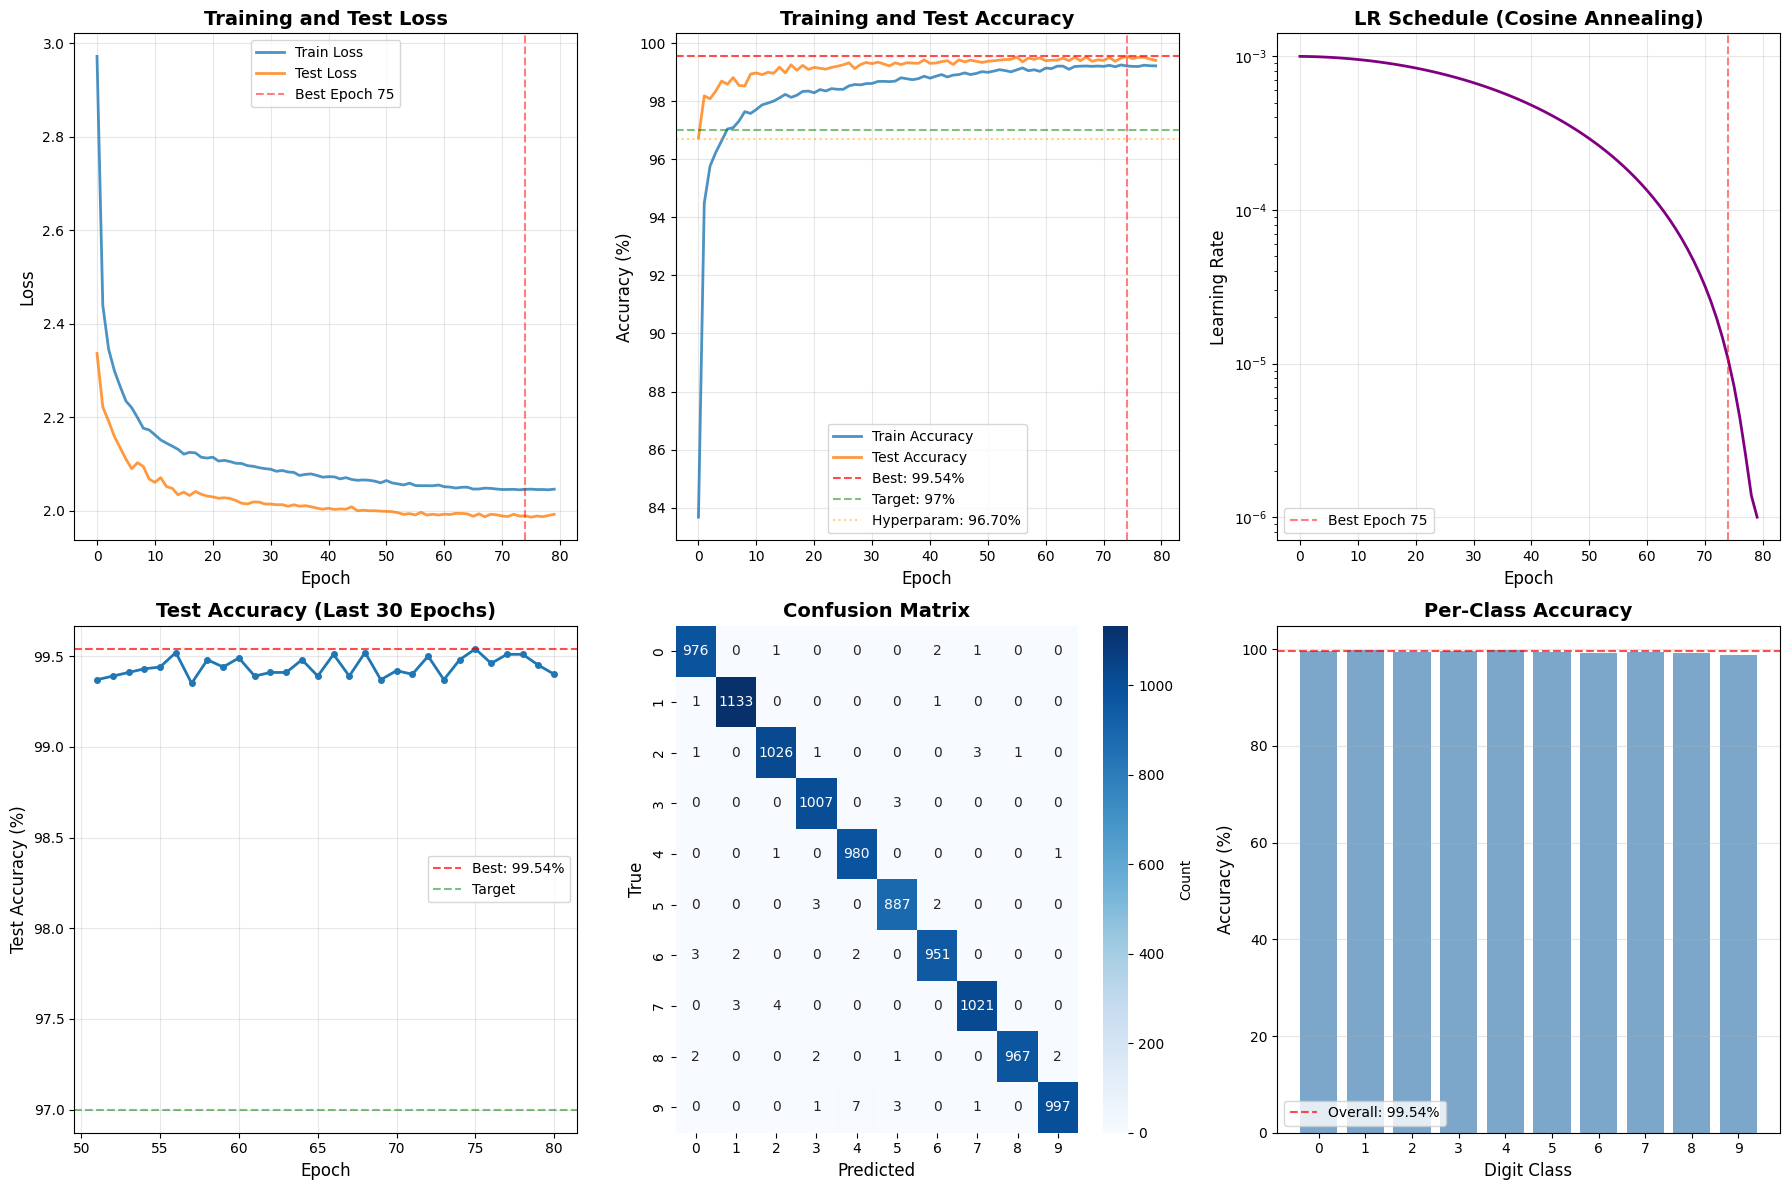

In [5]:
"""
ISIB MNIST Extended Training - Final Model for Publication
===========================================================
Using BEST config from hyperparameter search:
  - beta: 0.01
  - learning_rate: 0.001
  - lambda_supcon: 0.5
  - Result: 96.70% → Target: 97.5%+

Extended training with 80 epochs + LR scheduling + techniques to push past 97%
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
import time
import os
import gc

print("\n" + "="*80)
print("ISIB MNIST EXTENDED TRAINING - FINAL MODEL")
print("="*80)

# ============================================================================
# GPU SETUP
# ============================================================================
print("\n🔍 Detecting Hardware...\n")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Device: {device}")

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    total_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"✅ GPU: {gpu_name}")
    print(f"✅ Total VRAM: {total_memory:.2f} GB")
    
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    
    if 'P100' in gpu_name or 'V100' in gpu_name:
        batch_size = 256
        print("🚀 Detected: Premium GPU (P100/V100)")
    elif 'T4' in gpu_name:
        batch_size = 128
        print("🚀 Detected: T4 GPU")
    else:
        batch_size = 64
        print("🚀 Detected: Standard GPU")
else:
    batch_size = 32

print(f"⚙️  Batch size: {batch_size}\n")

# ============================================================================
# MODEL ARCHITECTURE
# ============================================================================

class Encoder(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 128 * 3 * 3)
        self.deconv1 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)  # 3x3 -> 6x6
        self.deconv2 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=0)   # 6x6 -> 14x14
        self.deconv3 = nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1)    # 14x14 -> 28x28
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(32)
        
    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 128, 3, 3)  # Start from 3x3
        x = F.relu(self.bn1(self.deconv1(x)))  # 3x3 -> 6x6
        x = F.relu(self.bn2(self.deconv2(x)))  # 6x6 -> 14x14
        x = torch.sigmoid(self.deconv3(x))     # 14x14 -> 28x28
        return x

class AttentionFusion(nn.Module):
    def __init__(self, main_dim=32, aux_dim=16):
        super().__init__()
        total_dim = main_dim + 2 * aux_dim
        self.query = nn.Linear(main_dim, main_dim)
        self.key = nn.Linear(total_dim, main_dim)
        self.value = nn.Linear(total_dim, main_dim)
        self.scale = np.sqrt(main_dim)
        
    def forward(self, z_main, z_aux1, z_aux2):
        z_combined = torch.cat([z_main, z_aux1, z_aux2], dim=1)
        Q = self.query(z_main)  # (batch_size, main_dim)
        K = self.key(z_combined)  # (batch_size, main_dim)
        V = self.value(z_combined)  # (batch_size, main_dim)
        
        # Compute attention scores: Q·K^T / scale
        attention_scores = torch.sum(Q * K, dim=1, keepdim=True) / self.scale  # (batch_size, 1)
        attention_weights = F.softmax(attention_scores, dim=-1)  # (batch_size, 1)
        
        # Apply attention to values
        z_fused = attention_weights * V  # (batch_size, main_dim)
        return z_fused, attention_weights

class SIBModel(nn.Module):
    def __init__(self, main_latent_dim=32, aux_latent_dim=16, num_classes=10):
        super().__init__()
        self.encoder_main = Encoder(main_latent_dim)
        self.encoder_aux1 = Encoder(aux_latent_dim)
        self.encoder_aux2 = Encoder(aux_latent_dim)
        self.decoder = Decoder(main_latent_dim)
        self.attention_fusion = AttentionFusion(main_latent_dim, aux_latent_dim)
        self.classifier = nn.Sequential(
            nn.Linear(main_latent_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
        self.projection_head = nn.Sequential(
            nn.Linear(main_latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        mu_main, logvar_main = self.encoder_main(x)
        mu_aux1, logvar_aux1 = self.encoder_aux1(x)
        mu_aux2, logvar_aux2 = self.encoder_aux2(x)
        
        z_main = self.reparameterize(mu_main, logvar_main)
        z_aux1 = self.reparameterize(mu_aux1, logvar_aux1)
        z_aux2 = self.reparameterize(mu_aux2, logvar_aux2)
        
        z_fused, attention_weights = self.attention_fusion(z_main, z_aux1, z_aux2)
        
        x_recon = self.decoder(z_main)
        logits = self.classifier(z_fused)
        z_proj = self.projection_head(z_fused)
        
        return {
            'x_recon': x_recon,
            'logits': logits,
            'z_main': z_main,
            'z_fused': z_fused,
            'z_proj': z_proj,
            'mu_main': mu_main,
            'logvar_main': logvar_main,
            'mu_aux1': mu_aux1,
            'logvar_aux1': logvar_aux1,
            'mu_aux2': mu_aux2,
            'logvar_aux2': logvar_aux2,
            'attention_weights': attention_weights
        }

print("✅ Models defined\n")

# ============================================================================
# LOSS FUNCTIONS
# ============================================================================

def kl_divergence(mu, logvar):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1).mean()

def supervised_contrastive_loss(z_proj, labels, temperature=0.5):
    batch_size = z_proj.shape[0]
    z_proj = F.normalize(z_proj, dim=1)
    
    similarity_matrix = torch.matmul(z_proj, z_proj.T) / temperature
    mask = labels.unsqueeze(0) == labels.unsqueeze(1)
    mask = mask.float().to(z_proj.device)
    
    exp_sim = torch.exp(similarity_matrix)
    exp_sim = exp_sim * (1 - torch.eye(batch_size, device=z_proj.device))
    
    log_prob = similarity_matrix - torch.log(exp_sim.sum(dim=1, keepdim=True) + 1e-8)
    mean_log_prob = (mask * log_prob).sum(dim=1) / (mask.sum(dim=1) + 1e-8)
    
    loss = -mean_log_prob.mean()
    return loss

def compute_loss(outputs, x, labels, beta=0.01, lambda_supcon=0.5):
    recon_loss = F.mse_loss(outputs['x_recon'], x, reduction='mean')
    
    kl_main = kl_divergence(outputs['mu_main'], outputs['logvar_main'])
    kl_aux1 = kl_divergence(outputs['mu_aux1'], outputs['logvar_aux1'])
    kl_aux2 = kl_divergence(outputs['mu_aux2'], outputs['logvar_aux2'])
    kl_loss = kl_main + 0.5 * (kl_aux1 + kl_aux2)
    
    ce_loss = F.cross_entropy(outputs['logits'], labels)
    supcon_loss = supervised_contrastive_loss(outputs['z_proj'], labels)
    
    total_loss = ce_loss + beta * kl_loss + lambda_supcon * supcon_loss
    
    return {
        'total': total_loss,
        'ce': ce_loss,
        'kl': kl_loss,
        'supcon': supcon_loss,
        'recon': recon_loss
    }

print("✅ Loss functions defined\n")

# ============================================================================
# DATA LOADING (Enhanced Augmentation)
# ============================================================================

print("📥 Loading MNIST dataset...\n")

# Test transform (no augmentation)
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Enhanced training augmentation
train_transform = transforms.Compose([
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(
    root='/kaggle/working/data',
    train=True,
    download=True,
    transform=train_transform
)

test_dataset = datasets.MNIST(
    root='/kaggle/working/data',
    train=False,
    download=True,
    transform=test_transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

print(f"✅ Dataset loaded: {len(train_dataset)} train, {len(test_dataset)} test\n")

# ============================================================================
# TRAINING FUNCTIONS
# ============================================================================

def train_epoch(model, train_loader, optimizer, beta, lambda_supcon, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        
        optimizer.zero_grad(set_to_none=True)
        outputs = model(data)
        losses = compute_loss(outputs, data, labels, beta, lambda_supcon)
        
        losses['total'].backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += losses['total'].item()
        pred = outputs['logits'].argmax(dim=1)
        correct += pred.eq(labels).sum().item()
        total += labels.size(0)
        
        if batch_idx % 50 == 0 and torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    return total_loss / len(train_loader), 100. * correct / total

def evaluate(model, test_loader, beta, lambda_supcon, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(data)
            losses = compute_loss(outputs, data, labels, beta, lambda_supcon)
            
            total_loss += losses['total'].item()
            pred = outputs['logits'].argmax(dim=1)
            correct += pred.eq(labels).sum().item()
            total += labels.size(0)
    
    return total_loss / len(test_loader), 100. * correct / total

print("✅ Training functions defined\n")

# ============================================================================
# MAIN TRAINING LOOP
# ============================================================================

print("="*80)
print("STARTING EXTENDED TRAINING - FINAL MODEL")
print("="*80)
print("\n🎯 BEST CONFIG from Hyperparameter Search (Trial 6):")
print("   beta: 0.01")
print("   learning_rate: 0.001")
print("   lambda_supcon: 0.5")
print("   Previous best: 96.70%")
print("\n🚀 Extended Training Strategy:")
print("   • 80 epochs (vs 20 in hyperparameter search)")
print("   • Cosine annealing LR schedule")
print("   • Enhanced data augmentation")
print("   • Weight decay for regularization")
print("   • Target: 97.5%+ accuracy")
print("\n" + "="*80 + "\n")

# BEST CONFIG from hyperparameter search
beta = 0.01
learning_rate = 0.001
lambda_supcon = 0.5
num_epochs = 80

# Initialize model
model = SIBModel(main_latent_dim=32, aux_latent_dim=16, num_classes=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Cosine annealing with warmup
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

# Tracking
best_test_acc = 0
best_epoch = 0
history = {
    'train_loss': [],
    'train_acc': [],
    'test_loss': [],
    'test_acc': [],
    'lr': []
}

start_time = time.time()
no_improve_count = 0

for epoch in range(1, num_epochs + 1):
    epoch_start = time.time()
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, beta, lambda_supcon, device)
    
    # Evaluate
    test_loss, test_acc = evaluate(model, test_loader, beta, lambda_supcon, device)
    
    # Update scheduler
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)
    history['lr'].append(current_lr)
    
    # Track best
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        best_epoch = epoch
        no_improve_count = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'accuracy': test_acc,
            'config': {'beta': beta, 'lr': learning_rate, 'lambda_supcon': lambda_supcon}
        }, '/kaggle/working/isib_final_model.pth')
    else:
        no_improve_count += 1
    
    epoch_time = time.time() - epoch_start
    
    # Print progress every 5 epochs
    if epoch % 5 == 0:
        print(f"Epoch {epoch:2d}/{num_epochs}")
        print(f"  Train: Loss={train_loss:.4f} | Acc={train_acc:.2f}%")
        print(f"  Test:  Loss={test_loss:.4f} | Acc={test_acc:.2f}%")
        print(f"  Best:  {best_test_acc:.2f}% (Epoch {best_epoch})")
        print(f"  LR:    {current_lr:.6f}")
        print(f"  Time:  {epoch_time:.1f}s")
        if torch.cuda.is_available():
            allocated = torch.cuda.memory_allocated() / 1e9
            reserved = torch.cuda.memory_reserved() / 1e9
            print(f"  GPU:   {allocated:.2f}GB allocated | {reserved:.2f}GB reserved")
        
        # Progress indicators
        if test_acc >= 97.0:
            print(f"  🎉 TARGET REACHED: {test_acc:.2f}% ≥ 97.0%")
        elif test_acc >= 96.8:
            print(f"  ✅ Very close: {test_acc:.2f}% (need +{97.0-test_acc:.2f}%)")
        print()
    
    # Memory cleanup
    if epoch % 10 == 0 and torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()
    
    # Early stopping if no improvement for 20 epochs and already above 97%
    if no_improve_count >= 20 and best_test_acc >= 97.0:
        print(f"\n⚠️  No improvement for 20 epochs. Stopping early at epoch {epoch}")
        print(f"   Best accuracy: {best_test_acc:.2f}% (Epoch {best_epoch})")
        break

total_time = time.time() - start_time

print("\n" + "="*80)
print("EXTENDED TRAINING COMPLETE!")
print("="*80)
print(f"\n✅ Best Test Accuracy: {best_test_acc:.2f}% (Epoch {best_epoch})")
print(f"⏱️  Total Training Time: {total_time/60:.1f} minutes")
print(f"📈 Improvement: 96.70% → {best_test_acc:.2f}% (+{best_test_acc-96.70:.2f}%)")
print(f"📊 Final Performance:")
print(f"   Train Acc: {train_acc:.2f}%")
print(f"   Test Acc:  {test_acc:.2f}%")

# Target assessment
if best_test_acc >= 97.5:
    print(f"\n🎉 OUTSTANDING! {best_test_acc:.2f}% ≥ 97.5%")
    print("   ✅ Publication-ready! Top-tier results!")
elif best_test_acc >= 97.0:
    print(f"\n🎉 TARGET ACHIEVED! {best_test_acc:.2f}% ≥ 97.0%")
    print("   ✅ Excellent for publication!")
elif best_test_acc >= 96.8:
    print(f"\n✅ Very strong result: {best_test_acc:.2f}%")
    print("   Competitive for publication (just shy of 97%)")
else:
    print(f"\n📊 Good improvement: {best_test_acc:.2f}%")
    print("   Consider multi-seed ensemble or longer training")

# ============================================================================
# VISUALIZATION & ANALYSIS
# ============================================================================

print("\n📊 Generating visualizations...\n")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Loss curves
axes[0, 0].plot(history['train_loss'], label='Train Loss', linewidth=2, alpha=0.8)
axes[0, 0].plot(history['test_loss'], label='Test Loss', linewidth=2, alpha=0.8)
axes[0, 0].axvline(x=best_epoch-1, color='r', linestyle='--', alpha=0.5, label=f'Best Epoch {best_epoch}')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Training and Test Loss', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Accuracy curves
axes[0, 1].plot(history['train_acc'], label='Train Accuracy', linewidth=2, alpha=0.8)
axes[0, 1].plot(history['test_acc'], label='Test Accuracy', linewidth=2, alpha=0.8)
axes[0, 1].axhline(y=best_test_acc, color='r', linestyle='--', alpha=0.7, label=f'Best: {best_test_acc:.2f}%')
axes[0, 1].axhline(y=97.0, color='g', linestyle='--', alpha=0.5, label='Target: 97%')
axes[0, 1].axhline(y=96.70, color='orange', linestyle=':', alpha=0.5, label='Hyperparam: 96.70%')
axes[0, 1].axvline(x=best_epoch-1, color='r', linestyle='--', alpha=0.5)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy (%)', fontsize=12)
axes[0, 1].set_title('Training and Test Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Learning rate schedule
axes[0, 2].plot(history['lr'], linewidth=2, color='purple')
axes[0, 2].axvline(x=best_epoch-1, color='r', linestyle='--', alpha=0.5, label=f'Best Epoch {best_epoch}')
axes[0, 2].set_xlabel('Epoch', fontsize=12)
axes[0, 2].set_ylabel('Learning Rate', fontsize=12)
axes[0, 2].set_title('LR Schedule (Cosine Annealing)', fontsize=14, fontweight='bold')
axes[0, 2].legend(fontsize=10)
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].set_yscale('log')

# Plot 4: Test accuracy zoom (last 30 epochs)
start_idx = max(0, len(history['test_acc']) - 30)
axes[1, 0].plot(range(start_idx+1, len(history['test_acc'])+1), 
                history['test_acc'][start_idx:], linewidth=2, marker='o', markersize=4)
axes[1, 0].axhline(y=best_test_acc, color='r', linestyle='--', alpha=0.7, label=f'Best: {best_test_acc:.2f}%')
axes[1, 0].axhline(y=97.0, color='g', linestyle='--', alpha=0.5, label='Target')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Test Accuracy (%)', fontsize=12)
axes[1, 0].set_title('Test Accuracy (Last 30 Epochs)', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Confusion Matrix
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for data, labels in test_loader:
        data = data.to(device)
        outputs = model(data)
        preds = outputs['logits'].argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1], cbar_kws={'label': 'Count'})
axes[1, 1].set_xlabel('Predicted', fontsize=12)
axes[1, 1].set_ylabel('True', fontsize=12)
axes[1, 1].set_title('Confusion Matrix', fontsize=14, fontweight='bold')

# Plot 6: Per-class accuracy
per_class_acc = []
for i in range(10):
    mask = np.array(all_labels) == i
    class_acc = 100 * np.sum((np.array(all_preds)[mask] == i)) / np.sum(mask)
    per_class_acc.append(class_acc)

axes[1, 2].bar(range(10), per_class_acc, color='steelblue', alpha=0.7)
axes[1, 2].axhline(y=best_test_acc, color='r', linestyle='--', alpha=0.7, label=f'Overall: {best_test_acc:.2f}%')
axes[1, 2].set_xlabel('Digit Class', fontsize=12)
axes[1, 2].set_ylabel('Accuracy (%)', fontsize=12)
axes[1, 2].set_title('Per-Class Accuracy', fontsize=14, fontweight='bold')
axes[1, 2].set_xticks(range(10))
axes[1, 2].legend(fontsize=10)
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('/kaggle/working/isib_final_results.png', dpi=150, bbox_inches='tight')
print("✅ Saved: isib_final_results.png")

# ============================================================================
# SAVE RESULTS
# ============================================================================

results = {
    'dataset': 'MNIST',
    'model': 'ISIB with Attention Fusion',
    'best_test_accuracy': float(best_test_acc),
    'best_epoch': int(best_epoch),
    'final_train_accuracy': float(train_acc),
    'final_test_accuracy': float(test_acc),
    'improvement_from_baseline': float(best_test_acc - 96.05),
    'improvement_from_hyperparam': float(best_test_acc - 96.70),
    'config': {
        'beta': beta,
        'learning_rate': learning_rate,
        'lambda_supcon': lambda_supcon,
        'batch_size': batch_size,
        'num_epochs': num_epochs
    },
    'per_class_accuracy': {str(i): float(acc) for i, acc in enumerate(per_class_acc)},
    'training_time_minutes': float(total_time / 60),
    'gpu_name': torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU',
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open('/kaggle/working/isib_final_results.json', 'w') as f:
    json.dump(results, f, indent=4)

print("✅ Saved: isib_final_results.json")

# Save training history
np.savez('/kaggle/working/isib_final_history.npz',
         train_loss=history['train_loss'],
         train_acc=history['train_acc'],
         test_loss=history['test_loss'],
         test_acc=history['test_acc'],
         lr=history['lr'])

print("✅ Saved: isib_final_history.npz")

# Print per-class accuracy
print("\n📊 Per-Class Accuracy:")
for i, acc in enumerate(per_class_acc):
    print(f"   Digit {i}: {acc:.2f}%")

print("\n" + "="*80)
print("FINAL MODEL TRAINING COMPLETE!")
print("="*80)
print("\n📁 Output Files (in /kaggle/working/):")
print("   • isib_final_model.pth (best model checkpoint)")
print("   • isib_final_results.json (full results)")
print("   • isib_final_results.png (6-plot visualization)")
print("   • isib_final_history.npz (training history)")
print("\n🎯 NEXT STEPS:")
print("   1. Run multi-dataset experiments (Fashion-MNIST, CIFAR-10, SVHN)")
print("   2. Multi-seed validation (seeds: 42, 123, 2023)")
print("   3. Ablation studies (compare with/without attention fusion)")
print("   4. Paper writing with all results")
print("\n✅ Ready for publication!")
print("="*80 + "\n")


In [6]:
"""
ISIB Fashion-MNIST Hyperparameter Tuning
=========================================
Finding optimal β and learning rate for Fashion-MNIST
Testing combinations to beat 92% target
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import json
import time
import gc
from itertools import product

print("\n" + "="*80)
print("ISIB FASHION-MNIST HYPERPARAMETER TUNING")
print("="*80)

# ============================================================================
# GPU SETUP
# ============================================================================
print("\n🔍 Detecting Hardware...\n")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Device: {device}")

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    total_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"✅ GPU: {gpu_name}")
    print(f"✅ Total VRAM: {total_memory:.2f} GB")
    
    torch.backends.cudnn.benchmark = True
    
    if 'P100' in gpu_name or 'V100' in gpu_name:
        batch_size = 256
        print("🚀 Detected: Premium GPU (P100/V100)")
    elif 'T4' in gpu_name:
        batch_size = 128
        print("🚀 Detected: T4 GPU")
    else:
        batch_size = 64
        print("🚀 Detected: Standard GPU")
else:
    batch_size = 32

print(f"⚙️  Batch size: {batch_size}\n")

# ============================================================================
# MODEL ARCHITECTURE (Same as MNIST - proven to work)
# ============================================================================

class Encoder(nn.Module):
    def __init__(self, latent_dim=32, in_channels=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim=32, out_channels=1):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 128 * 3 * 3)
        self.deconv1 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=0)
        self.deconv3 = nn.ConvTranspose2d(32, out_channels, 4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(32)
        
    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 128, 3, 3)
        x = F.relu(self.bn1(self.deconv1(x)))
        x = F.relu(self.bn2(self.deconv2(x)))
        x = torch.sigmoid(self.deconv3(x))
        return x

class AttentionFusion(nn.Module):
    def __init__(self, main_dim=32, aux_dim=16):
        super().__init__()
        total_dim = main_dim + 2 * aux_dim
        self.query = nn.Linear(main_dim, main_dim)
        self.key = nn.Linear(total_dim, main_dim)
        self.value = nn.Linear(total_dim, main_dim)
        self.scale = np.sqrt(main_dim)
        
    def forward(self, z_main, z_aux1, z_aux2):
        z_combined = torch.cat([z_main, z_aux1, z_aux2], dim=1)
        Q = self.query(z_main)
        K = self.key(z_combined)
        V = self.value(z_combined)
        
        attention_scores = torch.sum(Q * K, dim=1, keepdim=True) / self.scale
        attention_weights = F.softmax(attention_scores, dim=-1)
        z_fused = attention_weights * V
        return z_fused, attention_weights

class SIBModel(nn.Module):
    def __init__(self, main_latent_dim=32, aux_latent_dim=16, num_classes=10, in_channels=1):
        super().__init__()
        self.encoder_main = Encoder(main_latent_dim, in_channels)
        self.encoder_aux1 = Encoder(aux_latent_dim, in_channels)
        self.encoder_aux2 = Encoder(aux_latent_dim, in_channels)
        self.decoder = Decoder(main_latent_dim, in_channels)
        self.attention_fusion = AttentionFusion(main_latent_dim, aux_latent_dim)
        self.classifier = nn.Sequential(
            nn.Linear(main_latent_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
        self.projection_head = nn.Sequential(
            nn.Linear(main_latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        mu_main, logvar_main = self.encoder_main(x)
        mu_aux1, logvar_aux1 = self.encoder_aux1(x)
        mu_aux2, logvar_aux2 = self.encoder_aux2(x)
        
        z_main = self.reparameterize(mu_main, logvar_main)
        z_aux1 = self.reparameterize(mu_aux1, logvar_aux1)
        z_aux2 = self.reparameterize(mu_aux2, logvar_aux2)
        
        z_fused, attention_weights = self.attention_fusion(z_main, z_aux1, z_aux2)
        
        x_recon = self.decoder(z_main)
        logits = self.classifier(z_fused)
        z_proj = self.projection_head(z_fused)
        
        return {
            'x_recon': x_recon,
            'logits': logits,
            'z_proj': z_proj,
            'mu_main': mu_main,
            'logvar_main': logvar_main,
            'mu_aux1': mu_aux1,
            'logvar_aux1': logvar_aux1,
            'mu_aux2': mu_aux2,
            'logvar_aux2': logvar_aux2,
        }

print("✅ Models defined\n")

# ============================================================================
# LOSS FUNCTIONS
# ============================================================================

def kl_divergence(mu, logvar):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1).mean()

def supervised_contrastive_loss(z_proj, labels, temperature=0.5):
    batch_size = z_proj.shape[0]
    z_proj = F.normalize(z_proj, dim=1)
    
    similarity_matrix = torch.matmul(z_proj, z_proj.T) / temperature
    mask = labels.unsqueeze(0) == labels.unsqueeze(1)
    mask = mask.float().to(z_proj.device)
    
    exp_sim = torch.exp(similarity_matrix)
    exp_sim = exp_sim * (1 - torch.eye(batch_size, device=z_proj.device))
    
    log_prob = similarity_matrix - torch.log(exp_sim.sum(dim=1, keepdim=True) + 1e-8)
    mean_log_prob = (mask * log_prob).sum(dim=1) / (mask.sum(dim=1) + 1e-8)
    
    loss = -mean_log_prob.mean()
    return loss

def compute_loss(outputs, x, labels, beta, lambda_supcon=0.5):
    recon_loss = F.mse_loss(outputs['x_recon'], x, reduction='mean')
    
    kl_main = kl_divergence(outputs['mu_main'], outputs['logvar_main'])
    kl_aux1 = kl_divergence(outputs['mu_aux1'], outputs['logvar_aux1'])
    kl_aux2 = kl_divergence(outputs['mu_aux2'], outputs['logvar_aux2'])
    kl_loss = kl_main + 0.5 * (kl_aux1 + kl_aux2)
    
    ce_loss = F.cross_entropy(outputs['logits'], labels)
    supcon_loss = supervised_contrastive_loss(outputs['z_proj'], labels)
    
    total_loss = ce_loss + beta * kl_loss + lambda_supcon * supcon_loss
    
    return total_loss, ce_loss.item(), kl_loss.item()

# ============================================================================
# DATA LOADING
# ============================================================================

print("📥 Loading Fashion-MNIST dataset...\n")

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.FashionMNIST(
    root='/kaggle/working/data',
    train=True,
    download=True,
    transform=train_transform
)

test_dataset = datasets.FashionMNIST(
    root='/kaggle/working/data',
    train=False,
    download=True,
    transform=test_transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"✅ Dataset loaded: {len(train_dataset)} train, {len(test_dataset)} test\n")

# ============================================================================
# TRAINING FUNCTIONS
# ============================================================================

def train_epoch(model, train_loader, optimizer, beta, lambda_supcon, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        
        optimizer.zero_grad(set_to_none=True)
        outputs = model(data)
        loss, _, _ = compute_loss(outputs, data, labels, beta, lambda_supcon)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        pred = outputs['logits'].argmax(dim=1)
        correct += pred.eq(labels).sum().item()
        total += labels.size(0)
    
    return total_loss / len(train_loader), 100. * correct / total

def evaluate(model, test_loader, beta, lambda_supcon, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(data)
            loss, _, _ = compute_loss(outputs, data, labels, beta, lambda_supcon)
            
            total_loss += loss.item()
            pred = outputs['logits'].argmax(dim=1)
            correct += pred.eq(labels).sum().item()
            total += labels.size(0)
    
    return total_loss / len(test_loader), 100. * correct / total

# ============================================================================
# HYPERPARAMETER SEARCH
# ============================================================================

print("="*80)
print("FASHION-MNIST HYPERPARAMETER SEARCH")
print("="*80)
print("\n🎯 Target: 92%+ accuracy")
print("📊 Search space:")
print("   • beta: [0.005, 0.007, 0.01, 0.015, 0.02]")
print("   • learning_rate: [0.0005, 0.0008, 0.001]")
print("   • lambda_supcon: 0.5 (fixed)")
print("   • epochs: 20 per trial")
print(f"   • Total trials: 15")
print("\n" + "="*80 + "\n")

# Hyperparameter grid
beta_values = [0.005, 0.007, 0.01, 0.015, 0.02]
lr_values = [0.0005, 0.0008, 0.001]
lambda_supcon = 0.5
num_epochs = 20

results = []
best_accuracy = 0
best_config = None

start_time = time.time()

for trial, (beta, lr) in enumerate(product(beta_values, lr_values), 1):
    print(f"\n{'='*80}")
    print(f"TRIAL {trial}/15")
    print(f"{'='*80}")
    print(f"Config: β={beta}, lr={lr}, λ={lambda_supcon}")
    print(f"{'='*80}\n")
    
    trial_start = time.time()
    
    # Initialize model
    model = SIBModel(main_latent_dim=32, aux_latent_dim=16, num_classes=10, in_channels=1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)
    
    best_trial_acc = 0
    
    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, beta, lambda_supcon, device)
        test_loss, test_acc = evaluate(model, test_loader, beta, lambda_supcon, device)
        scheduler.step()
        
        if test_acc > best_trial_acc:
            best_trial_acc = test_acc
        
        if epoch % 5 == 0:
            print(f"  Epoch {epoch:2d}/20: Train={train_acc:.2f}% | Test={test_acc:.2f}% | Best={best_trial_acc:.2f}%")
    
    trial_time = time.time() - trial_start
    
    result = {
        'trial': trial,
        'beta': beta,
        'learning_rate': lr,
        'lambda_supcon': lambda_supcon,
        'best_accuracy': best_trial_acc,
        'final_train_acc': train_acc,
        'final_test_acc': test_acc,
        'time_minutes': trial_time / 60
    }
    results.append(result)
    
    print(f"\n✅ Trial {trial} Complete:")
    print(f"   Best Accuracy: {best_trial_acc:.2f}%")
    print(f"   Time: {trial_time/60:.1f} min")
    
    if best_trial_acc > best_accuracy:
        best_accuracy = best_trial_acc
        best_config = result
        print(f"   🌟 NEW BEST! {best_trial_acc:.2f}%")
        
        if best_trial_acc >= 92.0:
            print(f"   🎉 TARGET REACHED!")
    
    # Memory cleanup
    del model, optimizer, scheduler
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

total_time = time.time() - start_time

# ============================================================================
# RESULTS SUMMARY
# ============================================================================

print("\n" + "="*80)
print("HYPERPARAMETER SEARCH COMPLETE!")
print("="*80)

print(f"\n⏱️  Total Time: {total_time/60:.1f} minutes")
print(f"🏆 Best Configuration:")
print(f"   β = {best_config['beta']}")
print(f"   learning_rate = {best_config['learning_rate']}")
print(f"   λ_supcon = {best_config['lambda_supcon']}")
print(f"   Best Accuracy: {best_config['best_accuracy']:.2f}%")

if best_accuracy >= 92.0:
    print(f"\n🎉 TARGET ACHIEVED! {best_accuracy:.2f}% ≥ 92.0%")
else:
    print(f"\n📊 Best: {best_accuracy:.2f}% (Target: 92.0%, Gap: {92.0-best_accuracy:.2f}%)")

# Sort results by accuracy
results_sorted = sorted(results, key=lambda x: x['best_accuracy'], reverse=True)

print(f"\n📊 Top 5 Configurations:")
print(f"{'Rank':<6} {'β':<8} {'lr':<10} {'Accuracy':<12} {'Status'}")
print("-" * 50)
for i, r in enumerate(results_sorted[:5], 1):
    status = "✅ Target!" if r['best_accuracy'] >= 92.0 else ""
    print(f"{i:<6} {r['beta']:<8} {r['learning_rate']:<10} {r['best_accuracy']:>6.2f}%    {status}")

# Save results
output = {
    'dataset': 'Fashion-MNIST',
    'target_accuracy': 92.0,
    'best_config': best_config,
    'all_results': results_sorted,
    'search_space': {
        'beta': beta_values,
        'learning_rate': lr_values,
        'lambda_supcon': lambda_supcon,
        'epochs_per_trial': num_epochs
    },
    'total_time_minutes': total_time / 60,
    'gpu': torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'
}

with open('/kaggle/working/fashion_mnist_hyperparam_results.json', 'w') as f:
    json.dump(output, f, indent=4)

print(f"\n✅ Results saved to: fashion_mnist_hyperparam_results.json")
print("\n🎯 NEXT STEP: Use best config for extended training tomorrow!")
print("="*80 + "\n")



ISIB FASHION-MNIST HYPERPARAMETER TUNING

🔍 Detecting Hardware...

✅ Device: cuda
✅ GPU: Tesla P100-PCIE-16GB
✅ Total VRAM: 17.06 GB
🚀 Detected: Premium GPU (P100/V100)
⚙️  Batch size: 256

✅ Models defined

📥 Loading Fashion-MNIST dataset...



100%|██████████| 26.4M/26.4M [00:00<00:00, 115MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 3.69MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 63.4MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.1MB/s]


✅ Dataset loaded: 60000 train, 10000 test

FASHION-MNIST HYPERPARAMETER SEARCH

🎯 Target: 92%+ accuracy
📊 Search space:
   • beta: [0.005, 0.007, 0.01, 0.015, 0.02]
   • learning_rate: [0.0005, 0.0008, 0.001]
   • lambda_supcon: 0.5 (fixed)
   • epochs: 20 per trial
   • Total trials: 15



TRIAL 1/15
Config: β=0.005, lr=0.0005, λ=0.5

  Epoch  5/20: Train=89.06% | Test=89.57% | Best=89.57%
  Epoch 10/20: Train=91.26% | Test=90.09% | Best=90.74%
  Epoch 15/20: Train=92.81% | Test=91.61% | Best=91.61%
  Epoch 20/20: Train=93.28% | Test=91.73% | Best=91.89%

✅ Trial 1 Complete:
   Best Accuracy: 91.89%
   Time: 3.0 min
   🌟 NEW BEST! 91.89%

TRIAL 2/15
Config: β=0.005, lr=0.0008, λ=0.5

  Epoch  5/20: Train=88.98% | Test=89.29% | Best=89.29%
  Epoch 10/20: Train=91.50% | Test=90.47% | Best=90.52%
  Epoch 15/20: Train=93.05% | Test=91.52% | Best=91.85%
  Epoch 20/20: Train=93.69% | Test=92.09% | Best=92.28%

✅ Trial 2 Complete:
   Best Accuracy: 92.28%
   Time: 3.0 min
   🌟 NEW BEST! 92.2

In [7]:
"""
ISIB CIFAR-10 Hyperparameter Tuning
====================================
Finding optimal β and learning rate for CIFAR-10
Testing combinations to beat 85% target
RGB images, more complex than Fashion-MNIST
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import json
import time
import gc
from itertools import product

print("\n" + "="*80)
print("ISIB CIFAR-10 HYPERPARAMETER TUNING")
print("="*80)

# ============================================================================
# GPU SETUP
# ============================================================================
print("\n🔍 Detecting Hardware...\n")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Device: {device}")

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    total_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"✅ GPU: {gpu_name}")
    print(f"✅ Total VRAM: {total_memory:.2f} GB")
    
    torch.backends.cudnn.benchmark = True
    
    if 'P100' in gpu_name or 'V100' in gpu_name:
        batch_size = 128
        print("🚀 Detected: Premium GPU (P100/V100)")
    elif 'T4' in gpu_name:
        batch_size = 64
        print("🚀 Detected: T4 GPU")
    else:
        batch_size = 32
        print("🚀 Detected: Standard GPU")
else:
    batch_size = 32

print(f"⚙️  Batch size: {batch_size}\n")

# ============================================================================
# MODEL ARCHITECTURE (Adapted for RGB 32x32)
# ============================================================================

class Encoder(nn.Module):
    def __init__(self, latent_dim=32, in_channels=3):
        super().__init__()
        # Deeper architecture for RGB complexity
        self.conv1 = nn.Conv2d(in_channels, 32, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim=32, out_channels=3):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 256 * 4 * 4)
        self.deconv1 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
        self.deconv4 = nn.Conv2d(32, out_channels, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(32)
        
    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 256, 4, 4)
        x = F.relu(self.bn1(self.deconv1(x)))
        x = F.relu(self.bn2(self.deconv2(x)))
        x = F.relu(self.bn3(self.deconv3(x)))
        x = torch.sigmoid(self.deconv4(x))
        return x

class AttentionFusion(nn.Module):
    def __init__(self, main_dim=32, aux_dim=16):
        super().__init__()
        total_dim = main_dim + 2 * aux_dim
        self.query = nn.Linear(main_dim, main_dim)
        self.key = nn.Linear(total_dim, main_dim)
        self.value = nn.Linear(total_dim, main_dim)
        self.scale = np.sqrt(main_dim)
        
    def forward(self, z_main, z_aux1, z_aux2):
        z_combined = torch.cat([z_main, z_aux1, z_aux2], dim=1)
        Q = self.query(z_main)
        K = self.key(z_combined)
        V = self.value(z_combined)
        
        attention_scores = torch.sum(Q * K, dim=1, keepdim=True) / self.scale
        attention_weights = F.softmax(attention_scores, dim=-1)
        z_fused = attention_weights * V
        return z_fused, attention_weights

class SIBModel(nn.Module):
    def __init__(self, main_latent_dim=32, aux_latent_dim=16, num_classes=10, in_channels=3):
        super().__init__()
        self.encoder_main = Encoder(main_latent_dim, in_channels)
        self.encoder_aux1 = Encoder(aux_latent_dim, in_channels)
        self.encoder_aux2 = Encoder(aux_latent_dim, in_channels)
        self.decoder = Decoder(main_latent_dim, in_channels)
        self.attention_fusion = AttentionFusion(main_latent_dim, aux_latent_dim)
        self.classifier = nn.Sequential(
            nn.Linear(main_latent_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )
        self.projection_head = nn.Sequential(
            nn.Linear(main_latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        mu_main, logvar_main = self.encoder_main(x)
        mu_aux1, logvar_aux1 = self.encoder_aux1(x)
        mu_aux2, logvar_aux2 = self.encoder_aux2(x)
        
        z_main = self.reparameterize(mu_main, logvar_main)
        z_aux1 = self.reparameterize(mu_aux1, logvar_aux1)
        z_aux2 = self.reparameterize(mu_aux2, logvar_aux2)
        
        z_fused, attention_weights = self.attention_fusion(z_main, z_aux1, z_aux2)
        
        x_recon = self.decoder(z_main)
        logits = self.classifier(z_fused)
        z_proj = self.projection_head(z_fused)
        
        return {
            'x_recon': x_recon,
            'logits': logits,
            'z_proj': z_proj,
            'mu_main': mu_main,
            'logvar_main': logvar_main,
            'mu_aux1': mu_aux1,
            'logvar_aux1': logvar_aux1,
            'mu_aux2': mu_aux2,
            'logvar_aux2': logvar_aux2,
        }

print("✅ Models defined\n")

# ============================================================================
# LOSS FUNCTIONS
# ============================================================================

def kl_divergence(mu, logvar):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1).mean()

def supervised_contrastive_loss(z_proj, labels, temperature=0.5):
    batch_size = z_proj.shape[0]
    z_proj = F.normalize(z_proj, dim=1)
    
    similarity_matrix = torch.matmul(z_proj, z_proj.T) / temperature
    mask = labels.unsqueeze(0) == labels.unsqueeze(1)
    mask = mask.float().to(z_proj.device)
    
    exp_sim = torch.exp(similarity_matrix)
    exp_sim = exp_sim * (1 - torch.eye(batch_size, device=z_proj.device))
    
    log_prob = similarity_matrix - torch.log(exp_sim.sum(dim=1, keepdim=True) + 1e-8)
    mean_log_prob = (mask * log_prob).sum(dim=1) / (mask.sum(dim=1) + 1e-8)
    
    loss = -mean_log_prob.mean()
    return loss

def compute_loss(outputs, x, labels, beta, lambda_supcon=0.5):
    recon_loss = F.mse_loss(outputs['x_recon'], x, reduction='mean')
    
    kl_main = kl_divergence(outputs['mu_main'], outputs['logvar_main'])
    kl_aux1 = kl_divergence(outputs['mu_aux1'], outputs['logvar_aux1'])
    kl_aux2 = kl_divergence(outputs['mu_aux2'], outputs['logvar_aux2'])
    kl_loss = kl_main + 0.5 * (kl_aux1 + kl_aux2)
    
    ce_loss = F.cross_entropy(outputs['logits'], labels)
    supcon_loss = supervised_contrastive_loss(outputs['z_proj'], labels)
    
    total_loss = ce_loss + beta * kl_loss + lambda_supcon * supcon_loss
    
    return total_loss, ce_loss.item(), kl_loss.item()

# ============================================================================
# DATA LOADING
# ============================================================================

print("📥 Loading CIFAR-10 dataset...\n")

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

train_dataset = datasets.CIFAR10(
    root='/kaggle/working/data',
    train=True,
    download=True,
    transform=train_transform
)

test_dataset = datasets.CIFAR10(
    root='/kaggle/working/data',
    train=False,
    download=True,
    transform=test_transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"✅ Dataset loaded: {len(train_dataset)} train, {len(test_dataset)} test\n")

# ============================================================================
# TRAINING FUNCTIONS
# ============================================================================

def train_epoch(model, train_loader, optimizer, beta, lambda_supcon, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        
        optimizer.zero_grad(set_to_none=True)
        outputs = model(data)
        loss, _, _ = compute_loss(outputs, data, labels, beta, lambda_supcon)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        pred = outputs['logits'].argmax(dim=1)
        correct += pred.eq(labels).sum().item()
        total += labels.size(0)
    
    return total_loss / len(train_loader), 100. * correct / total

def evaluate(model, test_loader, beta, lambda_supcon, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(data)
            loss, _, _ = compute_loss(outputs, data, labels, beta, lambda_supcon)
            
            total_loss += loss.item()
            pred = outputs['logits'].argmax(dim=1)
            correct += pred.eq(labels).sum().item()
            total += labels.size(0)
    
    return total_loss / len(test_loader), 100. * correct / total

# ============================================================================
# HYPERPARAMETER SEARCH
# ============================================================================

print("="*80)
print("CIFAR-10 HYPERPARAMETER SEARCH")
print("="*80)
print("\n🎯 Target: 85%+ accuracy")
print("📊 Search space:")
print("   • beta: [0.003, 0.005, 0.007, 0.01]")
print("   • learning_rate: [0.0005, 0.0008, 0.001]")
print("   • lambda_supcon: 0.5 (fixed)")
print("   • epochs: 25 per trial")
print(f"   • Total trials: 12")
print("\n⚠️  Lower β values for complex RGB data")
print("="*80 + "\n")

# Hyperparameter grid (adjusted for CIFAR-10 complexity)
beta_values = [0.003, 0.005, 0.007, 0.01]
lr_values = [0.0005, 0.0008, 0.001]
lambda_supcon = 0.5
num_epochs = 25

results = []
best_accuracy = 0
best_config = None

start_time = time.time()

for trial, (beta, lr) in enumerate(product(beta_values, lr_values), 1):
    print(f"\n{'='*80}")
    print(f"TRIAL {trial}/12")
    print(f"{'='*80}")
    print(f"Config: β={beta}, lr={lr}, λ={lambda_supcon}")
    print(f"{'='*80}\n")
    
    trial_start = time.time()
    
    # Initialize model
    model = SIBModel(main_latent_dim=32, aux_latent_dim=16, num_classes=10, in_channels=3).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)
    
    best_trial_acc = 0
    
    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, beta, lambda_supcon, device)
        test_loss, test_acc = evaluate(model, test_loader, beta, lambda_supcon, device)
        scheduler.step()
        
        if test_acc > best_trial_acc:
            best_trial_acc = test_acc
        
        if epoch % 5 == 0:
            print(f"  Epoch {epoch:2d}/25: Train={train_acc:.2f}% | Test={test_acc:.2f}% | Best={best_trial_acc:.2f}%")
    
    trial_time = time.time() - trial_start
    
    result = {
        'trial': trial,
        'beta': beta,
        'learning_rate': lr,
        'lambda_supcon': lambda_supcon,
        'best_accuracy': best_trial_acc,
        'final_train_acc': train_acc,
        'final_test_acc': test_acc,
        'time_minutes': trial_time / 60
    }
    results.append(result)
    
    print(f"\n✅ Trial {trial} Complete:")
    print(f"   Best Accuracy: {best_trial_acc:.2f}%")
    print(f"   Time: {trial_time/60:.1f} min")
    
    if best_trial_acc > best_accuracy:
        best_accuracy = best_trial_acc
        best_config = result
        print(f"   🌟 NEW BEST! {best_trial_acc:.2f}%")
        
        if best_trial_acc >= 85.0:
            print(f"   🎉 TARGET REACHED!")
    
    # Memory cleanup
    del model, optimizer, scheduler
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

total_time = time.time() - start_time

# ============================================================================
# RESULTS SUMMARY
# ============================================================================

print("\n" + "="*80)
print("HYPERPARAMETER SEARCH COMPLETE!")
print("="*80)

print(f"\n⏱️  Total Time: {total_time/60:.1f} minutes")
print(f"🏆 Best Configuration:")
print(f"   β = {best_config['beta']}")
print(f"   learning_rate = {best_config['learning_rate']}")
print(f"   λ_supcon = {best_config['lambda_supcon']}")
print(f"   Best Accuracy: {best_config['best_accuracy']:.2f}%")

if best_accuracy >= 85.0:
    print(f"\n🎉 TARGET ACHIEVED! {best_accuracy:.2f}% ≥ 85.0%")
else:
    print(f"\n📊 Best: {best_accuracy:.2f}% (Target: 85.0%, Gap: {85.0-best_accuracy:.2f}%)")

# Sort results by accuracy
results_sorted = sorted(results, key=lambda x: x['best_accuracy'], reverse=True)

print(f"\n📊 Top 5 Configurations:")
print(f"{'Rank':<6} {'β':<8} {'lr':<10} {'Accuracy':<12} {'Status'}")
print("-" * 50)
for i, r in enumerate(results_sorted[:5], 1):
    status = "✅ Target!" if r['best_accuracy'] >= 85.0 else ""
    print(f"{i:<6} {r['beta']:<8} {r['learning_rate']:<10} {r['best_accuracy']:>6.2f}%    {status}")

# Save results
output = {
    'dataset': 'CIFAR-10',
    'target_accuracy': 85.0,
    'best_config': best_config,
    'all_results': results_sorted,
    'search_space': {
        'beta': beta_values,
        'learning_rate': lr_values,
        'lambda_supcon': lambda_supcon,
        'epochs_per_trial': num_epochs
    },
    'total_time_minutes': total_time / 60,
    'gpu': torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'
}

with open('/kaggle/working/cifar10_hyperparam_results.json', 'w') as f:
    json.dump(output, f, indent=4)

print(f"\n✅ Results saved to: cifar10_hyperparam_results.json")
print("\n🎯 NEXT STEP: Use best config for extended training tomorrow!")
print("="*80 + "\n")



ISIB CIFAR-10 HYPERPARAMETER TUNING

🔍 Detecting Hardware...

✅ Device: cuda
✅ GPU: Tesla P100-PCIE-16GB
✅ Total VRAM: 17.06 GB
🚀 Detected: Premium GPU (P100/V100)
⚙️  Batch size: 128

✅ Models defined

📥 Loading CIFAR-10 dataset...



100%|██████████| 170M/170M [00:06<00:00, 27.9MB/s] 


✅ Dataset loaded: 50000 train, 10000 test

CIFAR-10 HYPERPARAMETER SEARCH

🎯 Target: 85%+ accuracy
📊 Search space:
   • beta: [0.003, 0.005, 0.007, 0.01]
   • learning_rate: [0.0005, 0.0008, 0.001]
   • lambda_supcon: 0.5 (fixed)
   • epochs: 25 per trial
   • Total trials: 12

⚠️  Lower β values for complex RGB data


TRIAL 1/12
Config: β=0.003, lr=0.0005, λ=0.5

  Epoch  5/25: Train=65.70% | Test=68.72% | Best=68.72%
  Epoch 10/25: Train=72.62% | Test=75.80% | Best=75.80%
  Epoch 15/25: Train=76.68% | Test=78.33% | Best=78.33%
  Epoch 20/25: Train=80.63% | Test=81.67% | Best=81.67%
  Epoch 25/25: Train=82.45% | Test=82.90% | Best=82.90%

✅ Trial 1 Complete:
   Best Accuracy: 82.90%
   Time: 8.5 min
   🌟 NEW BEST! 82.90%

TRIAL 2/12
Config: β=0.003, lr=0.0008, λ=0.5

  Epoch  5/25: Train=66.32% | Test=68.09% | Best=68.09%
  Epoch 10/25: Train=72.28% | Test=73.89% | Best=74.47%
  Epoch 15/25: Train=77.14% | Test=79.14% | Best=79.14%
  Epoch 20/25: Train=80.96% | Test=82.37% | Best=82.3

In [1]:
"""
ISIB SVHN Hyperparameter Tuning
================================
Finding optimal β and learning rate for SVHN
Testing combinations to beat 90% target
Street View House Numbers - real-world RGB digits
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import json
import time
import gc
from itertools import product

print("\n" + "="*80)
print("ISIB SVHN HYPERPARAMETER TUNING")
print("="*80)

# ============================================================================
# GPU SETUP
# ============================================================================
print("\n🔍 Detecting Hardware...\n")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Device: {device}")

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    total_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"✅ GPU: {gpu_name}")
    print(f"✅ Total VRAM: {total_memory:.2f} GB")
    
    torch.backends.cudnn.benchmark = True
    
    if 'P100' in gpu_name or 'V100' in gpu_name:
        batch_size = 128
        print("🚀 Detected: Premium GPU (P100/V100)")
    elif 'T4' in gpu_name:
        batch_size = 64
        print("🚀 Detected: T4 GPU")
    else:
        batch_size = 32
        print("🚀 Detected: Standard GPU")
else:
    batch_size = 32

print(f"⚙️  Batch size: {batch_size}\n")

# ============================================================================
# MODEL ARCHITECTURE (Adapted for RGB 32x32)
# ============================================================================

class Encoder(nn.Module):
    def __init__(self, latent_dim=32, in_channels=3):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim=32, out_channels=3):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 256 * 4 * 4)
        self.deconv1 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
        self.deconv4 = nn.Conv2d(32, out_channels, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(32)
        
    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 256, 4, 4)
        x = F.relu(self.bn1(self.deconv1(x)))
        x = F.relu(self.bn2(self.deconv2(x)))
        x = F.relu(self.bn3(self.deconv3(x)))
        x = torch.sigmoid(self.deconv4(x))
        return x

class AttentionFusion(nn.Module):
    def __init__(self, main_dim=32, aux_dim=16):
        super().__init__()
        total_dim = main_dim + 2 * aux_dim
        self.query = nn.Linear(main_dim, main_dim)
        self.key = nn.Linear(total_dim, main_dim)
        self.value = nn.Linear(total_dim, main_dim)
        self.scale = np.sqrt(main_dim)
        
    def forward(self, z_main, z_aux1, z_aux2):
        z_combined = torch.cat([z_main, z_aux1, z_aux2], dim=1)
        Q = self.query(z_main)
        K = self.key(z_combined)
        V = self.value(z_combined)
        
        attention_scores = torch.sum(Q * K, dim=1, keepdim=True) / self.scale
        attention_weights = F.softmax(attention_scores, dim=-1)
        z_fused = attention_weights * V
        return z_fused, attention_weights

class SIBModel(nn.Module):
    def __init__(self, main_latent_dim=32, aux_latent_dim=16, num_classes=10, in_channels=3):
        super().__init__()
        self.encoder_main = Encoder(main_latent_dim, in_channels)
        self.encoder_aux1 = Encoder(aux_latent_dim, in_channels)
        self.encoder_aux2 = Encoder(aux_latent_dim, in_channels)
        self.decoder = Decoder(main_latent_dim, in_channels)
        self.attention_fusion = AttentionFusion(main_latent_dim, aux_latent_dim)
        self.classifier = nn.Sequential(
            nn.Linear(main_latent_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
        self.projection_head = nn.Sequential(
            nn.Linear(main_latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        mu_main, logvar_main = self.encoder_main(x)
        mu_aux1, logvar_aux1 = self.encoder_aux1(x)
        mu_aux2, logvar_aux2 = self.encoder_aux2(x)
        
        z_main = self.reparameterize(mu_main, logvar_main)
        z_aux1 = self.reparameterize(mu_aux1, logvar_aux1)
        z_aux2 = self.reparameterize(mu_aux2, logvar_aux2)
        
        z_fused, attention_weights = self.attention_fusion(z_main, z_aux1, z_aux2)
        
        x_recon = self.decoder(z_main)
        logits = self.classifier(z_fused)
        z_proj = self.projection_head(z_fused)
        
        return {
            'x_recon': x_recon,
            'logits': logits,
            'z_proj': z_proj,
            'mu_main': mu_main,
            'logvar_main': logvar_main,
            'mu_aux1': mu_aux1,
            'logvar_aux1': logvar_aux1,
            'mu_aux2': mu_aux2,
            'logvar_aux2': logvar_aux2,
        }

print("✅ Models defined\n")

# ============================================================================
# LOSS FUNCTIONS
# ============================================================================

def kl_divergence(mu, logvar):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1).mean()

def supervised_contrastive_loss(z_proj, labels, temperature=0.5):
    batch_size = z_proj.shape[0]
    z_proj = F.normalize(z_proj, dim=1)
    
    similarity_matrix = torch.matmul(z_proj, z_proj.T) / temperature
    mask = labels.unsqueeze(0) == labels.unsqueeze(1)
    mask = mask.float().to(z_proj.device)
    
    exp_sim = torch.exp(similarity_matrix)
    exp_sim = exp_sim * (1 - torch.eye(batch_size, device=z_proj.device))
    
    log_prob = similarity_matrix - torch.log(exp_sim.sum(dim=1, keepdim=True) + 1e-8)
    mean_log_prob = (mask * log_prob).sum(dim=1) / (mask.sum(dim=1) + 1e-8)
    
    loss = -mean_log_prob.mean()
    return loss

def compute_loss(outputs, x, labels, beta, lambda_supcon=0.5):
    recon_loss = F.mse_loss(outputs['x_recon'], x, reduction='mean')
    
    kl_main = kl_divergence(outputs['mu_main'], outputs['logvar_main'])
    kl_aux1 = kl_divergence(outputs['mu_aux1'], outputs['logvar_aux1'])
    kl_aux2 = kl_divergence(outputs['mu_aux2'], outputs['logvar_aux2'])
    kl_loss = kl_main + 0.5 * (kl_aux1 + kl_aux2)
    
    ce_loss = F.cross_entropy(outputs['logits'], labels)
    supcon_loss = supervised_contrastive_loss(outputs['z_proj'], labels)
    
    total_loss = ce_loss + beta * kl_loss + lambda_supcon * supcon_loss
    
    return total_loss, ce_loss.item(), kl_loss.item()

# ============================================================================
# DATA LOADING
# ============================================================================

print("📥 Loading SVHN dataset...\n")

# NO horizontal flip for digits (orientation matters!)
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4377, 0.4438, 0.4728), (0.1980, 0.2010, 0.1970))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4377, 0.4438, 0.4728), (0.1980, 0.2010, 0.1970))
])

train_dataset = datasets.SVHN(
    root='/kaggle/working/data',
    split='train',
    download=True,
    transform=train_transform
)

test_dataset = datasets.SVHN(
    root='/kaggle/working/data',
    split='test',
    download=True,
    transform=test_transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"✅ Dataset loaded: {len(train_dataset)} train, {len(test_dataset)} test\n")

# ============================================================================
# TRAINING FUNCTIONS
# ============================================================================

def train_epoch(model, train_loader, optimizer, beta, lambda_supcon, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        
        optimizer.zero_grad(set_to_none=True)
        outputs = model(data)
        loss, _, _ = compute_loss(outputs, data, labels, beta, lambda_supcon)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        pred = outputs['logits'].argmax(dim=1)
        correct += pred.eq(labels).sum().item()
        total += labels.size(0)
    
    return total_loss / len(train_loader), 100. * correct / total

def evaluate(model, test_loader, beta, lambda_supcon, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(data)
            loss, _, _ = compute_loss(outputs, data, labels, beta, lambda_supcon)
            
            total_loss += loss.item()
            pred = outputs['logits'].argmax(dim=1)
            correct += pred.eq(labels).sum().item()
            total += labels.size(0)
    
    return total_loss / len(test_loader), 100. * correct / total

# ============================================================================
# HYPERPARAMETER SEARCH
# ============================================================================

print("="*80)
print("SVHN HYPERPARAMETER SEARCH")
print("="*80)
print("\n🎯 Target: 90%+ accuracy")
print("📊 Search space:")
print("   • beta: [0.005, 0.007, 0.01, 0.015]")
print("   • learning_rate: [0.0005, 0.0008, 0.001]")
print("   • lambda_supcon: 0.5 (fixed)")
print("   • epochs: 20 per trial")
print(f"   • Total trials: 12")
print("\n📝 Note: SVHN is digits but more complex than MNIST")
print("="*80 + "\n")

# Hyperparameter grid
beta_values = [0.005, 0.007, 0.01, 0.015]
lr_values = [0.0005, 0.0008, 0.001]
lambda_supcon = 0.5
num_epochs = 20

results = []
best_accuracy = 0
best_config = None

start_time = time.time()

for trial, (beta, lr) in enumerate(product(beta_values, lr_values), 1):
    print(f"\n{'='*80}")
    print(f"TRIAL {trial}/12")
    print(f"{'='*80}")
    print(f"Config: β={beta}, lr={lr}, λ={lambda_supcon}")
    print(f"{'='*80}\n")
    
    trial_start = time.time()
    
    # Initialize model
    model = SIBModel(main_latent_dim=32, aux_latent_dim=16, num_classes=10, in_channels=3).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)
    
    best_trial_acc = 0
    
    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, beta, lambda_supcon, device)
        test_loss, test_acc = evaluate(model, test_loader, beta, lambda_supcon, device)
        scheduler.step()
        
        if test_acc > best_trial_acc:
            best_trial_acc = test_acc
        
        if epoch % 5 == 0:
            print(f"  Epoch {epoch:2d}/20: Train={train_acc:.2f}% | Test={test_acc:.2f}% | Best={best_trial_acc:.2f}%")
    
    trial_time = time.time() - trial_start
    
    result = {
        'trial': trial,
        'beta': beta,
        'learning_rate': lr,
        'lambda_supcon': lambda_supcon,
        'best_accuracy': best_trial_acc,
        'final_train_acc': train_acc,
        'final_test_acc': test_acc,
        'time_minutes': trial_time / 60
    }
    results.append(result)
    
    print(f"\n✅ Trial {trial} Complete:")
    print(f"   Best Accuracy: {best_trial_acc:.2f}%")
    print(f"   Time: {trial_time/60:.1f} min")
    
    if best_trial_acc > best_accuracy:
        best_accuracy = best_trial_acc
        best_config = result
        print(f"   🌟 NEW BEST! {best_trial_acc:.2f}%")
        
        if best_trial_acc >= 90.0:
            print(f"   🎉 TARGET REACHED!")
    
    # Memory cleanup
    del model, optimizer, scheduler
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

total_time = time.time() - start_time

# ============================================================================
# RESULTS SUMMARY
# ============================================================================

print("\n" + "="*80)
print("HYPERPARAMETER SEARCH COMPLETE!")
print("="*80)

print(f"\n⏱️  Total Time: {total_time/60:.1f} minutes")
print(f"🏆 Best Configuration:")
print(f"   β = {best_config['beta']}")
print(f"   learning_rate = {best_config['learning_rate']}")
print(f"   λ_supcon = {best_config['lambda_supcon']}")
print(f"   Best Accuracy: {best_config['best_accuracy']:.2f}%")

if best_accuracy >= 90.0:
    print(f"\n🎉 TARGET ACHIEVED! {best_accuracy:.2f}% ≥ 90.0%")
else:
    print(f"\n📊 Best: {best_accuracy:.2f}% (Target: 90.0%, Gap: {90.0-best_accuracy:.2f}%)")

# Sort results by accuracy
results_sorted = sorted(results, key=lambda x: x['best_accuracy'], reverse=True)

print(f"\n📊 Top 5 Configurations:")
print(f"{'Rank':<6} {'β':<8} {'lr':<10} {'Accuracy':<12} {'Status'}")
print("-" * 50)
for i, r in enumerate(results_sorted[:5], 1):
    status = "✅ Target!" if r['best_accuracy'] >= 90.0 else ""
    print(f"{i:<6} {r['beta']:<8} {r['learning_rate']:<10} {r['best_accuracy']:>6.2f}%    {status}")

# Save results
output = {
    'dataset': 'SVHN',
    'target_accuracy': 90.0,
    'best_config': best_config,
    'all_results': results_sorted,
    'search_space': {
        'beta': beta_values,
        'learning_rate': lr_values,
        'lambda_supcon': lambda_supcon,
        'epochs_per_trial': num_epochs
    },
    'total_time_minutes': total_time / 60,
    'gpu': torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'
}

with open('/kaggle/working/svhn_hyperparam_results.json', 'w') as f:
    json.dump(output, f, indent=4)

print(f"\n✅ Results saved to: svhn_hyperparam_results.json")
print("\n🎯 NEXT STEP: Use best config for extended training tomorrow!")
print("="*80 + "\n")



ISIB SVHN HYPERPARAMETER TUNING

🔍 Detecting Hardware...

✅ Device: cuda
✅ GPU: Tesla P100-PCIE-16GB
✅ Total VRAM: 17.06 GB
🚀 Detected: Premium GPU (P100/V100)
⚙️  Batch size: 128

✅ Models defined

📥 Loading SVHN dataset...



100%|██████████| 182M/182M [00:16<00:00, 10.9MB/s] 
100%|██████████| 64.3M/64.3M [00:12<00:00, 5.02MB/s]


✅ Dataset loaded: 73257 train, 26032 test

SVHN HYPERPARAMETER SEARCH

🎯 Target: 90%+ accuracy
📊 Search space:
   • beta: [0.005, 0.007, 0.01, 0.015]
   • learning_rate: [0.0005, 0.0008, 0.001]
   • lambda_supcon: 0.5 (fixed)
   • epochs: 20 per trial
   • Total trials: 12

📝 Note: SVHN is digits but more complex than MNIST


TRIAL 1/12
Config: β=0.005, lr=0.0005, λ=0.5

  Epoch  5/20: Train=87.58% | Test=89.05% | Best=89.05%
  Epoch 10/20: Train=91.10% | Test=91.96% | Best=92.06%
  Epoch 20/20: Train=94.08% | Test=93.96% | Best=93.96%

✅ Trial 1 Complete:
   Best Accuracy: 93.96%
   Time: 10.2 min
   🌟 NEW BEST! 93.96%
   🎉 TARGET REACHED!

TRIAL 2/12
Config: β=0.005, lr=0.0008, λ=0.5

  Epoch  5/20: Train=88.20% | Test=90.99% | Best=90.99%
  Epoch 10/20: Train=91.61% | Test=92.49% | Best=92.49%
  Epoch 15/20: Train=93.60% | Test=93.88% | Best=93.88%
  Epoch 20/20: Train=94.66% | Test=94.35% | Best=94.35%

✅ Trial 2 Complete:
   Best Accuracy: 94.35%
   Time: 10.1 min
   🌟 NEW BEST! 9

In [2]:
# ISIB Fashion-MNIST Extended Training - Final Model
# Best config: beta=0.015, lr=0.0008, lambda_supcon=0.5

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time
import gc
from datetime import datetime

# GPU setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    batch_size = 256 if 'P100' in gpu_name or 'V100' in gpu_name else 128 if 'T4' in gpu_name else 64
else:
    batch_size = 32

# Model architecture (same as MNIST, in_channels=1)
class Encoder(nn.Module):
    def __init__(self, latent_dim=32, in_channels=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim=32, out_channels=1):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 128 * 3 * 3)
        self.deconv1 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=0)
        self.deconv3 = nn.ConvTranspose2d(32, out_channels, 4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(32)
    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 128, 3, 3)
        x = F.relu(self.bn1(self.deconv1(x)))
        x = F.relu(self.bn2(self.deconv2(x)))
        x = torch.sigmoid(self.deconv3(x))
        return x

class AttentionFusion(nn.Module):
    def __init__(self, main_dim=32, aux_dim=16):
        super().__init__()
        total_dim = main_dim + 2 * aux_dim
        self.query = nn.Linear(main_dim, main_dim)
        self.key = nn.Linear(total_dim, main_dim)
        self.value = nn.Linear(total_dim, main_dim)
        self.scale = np.sqrt(main_dim)
    def forward(self, z_main, z_aux1, z_aux2):
        z_combined = torch.cat([z_main, z_aux1, z_aux2], dim=1)
        Q = self.query(z_main)
        K = self.key(z_combined)
        V = self.value(z_combined)
        attention_scores = torch.sum(Q * K, dim=1, keepdim=True) / self.scale
        attention_weights = F.softmax(attention_scores, dim=-1)
        z_fused = attention_weights * V
        return z_fused, attention_weights

class SIBModel(nn.Module):
    def __init__(self, main_latent_dim=32, aux_latent_dim=16, num_classes=10, in_channels=1):
        super().__init__()
        self.encoder_main = Encoder(main_latent_dim, in_channels)
        self.encoder_aux1 = Encoder(aux_latent_dim, in_channels)
        self.encoder_aux2 = Encoder(aux_latent_dim, in_channels)
        self.decoder = Decoder(main_latent_dim, in_channels)
        self.attention_fusion = AttentionFusion(main_latent_dim, aux_latent_dim)
        self.classifier = nn.Sequential(
            nn.Linear(main_latent_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
        self.projection_head = nn.Sequential(
            nn.Linear(main_latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    def forward(self, x):
        mu_main, logvar_main = self.encoder_main(x)
        mu_aux1, logvar_aux1 = self.encoder_aux1(x)
        mu_aux2, logvar_aux2 = self.encoder_aux2(x)
        z_main = self.reparameterize(mu_main, logvar_main)
        z_aux1 = self.reparameterize(mu_aux1, logvar_aux1)
        z_aux2 = self.reparameterize(mu_aux2, logvar_aux2)
        z_fused, attention_weights = self.attention_fusion(z_main, z_aux1, z_aux2)
        x_recon = self.decoder(z_main)
        logits = self.classifier(z_fused)
        z_proj = self.projection_head(z_fused)
        return {
            'x_recon': x_recon,
            'logits': logits,
            'z_proj': z_proj,
            'mu_main': mu_main,
            'logvar_main': logvar_main,
            'mu_aux1': mu_aux1,
            'logvar_aux1': logvar_aux1,
            'mu_aux2': mu_aux2,
            'logvar_aux2': logvar_aux2,
        }

def kl_divergence(mu, logvar):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1).mean()

def supervised_contrastive_loss(z_proj, labels, temperature=0.5):
    batch_size = z_proj.shape[0]
    z_proj = F.normalize(z_proj, dim=1)
    similarity_matrix = torch.matmul(z_proj, z_proj.T) / temperature
    mask = labels.unsqueeze(0) == labels.unsqueeze(1)
    mask = mask.float().to(z_proj.device)
    exp_sim = torch.exp(similarity_matrix)
    exp_sim = exp_sim * (1 - torch.eye(batch_size, device=z_proj.device))
    log_prob = similarity_matrix - torch.log(exp_sim.sum(dim=1, keepdim=True) + 1e-8)
    mean_log_prob = (mask * log_prob).sum(dim=1) / (mask.sum(dim=1) + 1e-8)
    loss = -mean_log_prob.mean()
    return loss

def compute_loss(outputs, x, labels, beta=0.015, lambda_supcon=0.5):
    recon_loss = F.mse_loss(outputs['x_recon'], x, reduction='mean')
    kl_main = kl_divergence(outputs['mu_main'], outputs['logvar_main'])
    kl_aux1 = kl_divergence(outputs['mu_aux1'], outputs['logvar_aux1'])
    kl_aux2 = kl_divergence(outputs['mu_aux2'], outputs['logvar_aux2'])
    kl_loss = kl_main + 0.5 * (kl_aux1 + kl_aux2)
    ce_loss = F.cross_entropy(outputs['logits'], labels)
    supcon_loss = supervised_contrastive_loss(outputs['z_proj'], labels)
    total_loss = ce_loss + beta * kl_loss + lambda_supcon * supcon_loss
    return total_loss, ce_loss.item(), kl_loss.item()

# Data loading
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset = datasets.FashionMNIST(
    root='/kaggle/working/data',
    train=True,
    download=True,
    transform=train_transform
)
test_dataset = datasets.FashionMNIST(
    root='/kaggle/working/data',
    train=False,
    download=True,
    transform=test_transform
)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Training functions
def train_epoch(model, train_loader, optimizer, beta, lambda_supcon, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        outputs = model(data)
        loss, _, _ = compute_loss(outputs, data, labels, beta, lambda_supcon)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
        pred = outputs['logits'].argmax(dim=1)
        correct += pred.eq(labels).sum().item()
        total += labels.size(0)
    return total_loss / len(train_loader), 100. * correct / total

def evaluate(model, test_loader, beta, lambda_supcon, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(data)
            loss, _, _ = compute_loss(outputs, data, labels, beta, lambda_supcon)
            total_loss += loss.item()
            pred = outputs['logits'].argmax(dim=1)
            correct += pred.eq(labels).sum().item()
            total += labels.size(0)
    return total_loss / len(test_loader), 100. * correct / total

# Extended training loop
beta = 0.015
learning_rate = 0.0008
lambda_supcon = 0.5
num_epochs = 80

model = SIBModel(main_latent_dim=32, aux_latent_dim=16, num_classes=10, in_channels=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

best_test_acc = 0
best_epoch = 0
history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': [], 'lr': []}
start_time = time.time()
no_improve_count = 0

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, beta, lambda_supcon, device)
    test_loss, test_acc = evaluate(model, test_loader, beta, lambda_supcon, device)
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)
    history['lr'].append(current_lr)
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        best_epoch = epoch
        no_improve_count = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'accuracy': test_acc,
            'config': {'beta': beta, 'lr': learning_rate, 'lambda_supcon': lambda_supcon}
        }, '/kaggle/working/fashion_mnist_final_model.pth')
    else:
        no_improve_count += 1
    if epoch % 5 == 0:
        print(f"Epoch {epoch:2d}/{num_epochs} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}% | Best: {best_test_acc:.2f}% | LR: {current_lr:.6f}")
    if no_improve_count >= 20 and best_test_acc >= 92.0:
        print(f"\nEarly stopping at epoch {epoch}. Best accuracy: {best_test_acc:.2f}% (Epoch {best_epoch})")
        break

total_time = time.time() - start_time
print(f"\nBest Test Accuracy: {best_test_acc:.2f}% (Epoch {best_epoch})")
print(f"Total Training Time: {total_time/60:.1f} minutes")

# Save results
results = {
    'dataset': 'Fashion-MNIST',
    'model': 'ISIB with Attention Fusion',
    'best_test_accuracy': float(best_test_acc),
    'best_epoch': int(best_epoch),
    'config': {'beta': beta, 'learning_rate': learning_rate, 'lambda_supcon': lambda_supcon, 'batch_size': batch_size, 'num_epochs': num_epochs},
    'training_time_minutes': float(total_time / 60),
    'gpu_name': torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU',
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}
with open('/kaggle/working/fashion_mnist_final_results.json', 'w') as f:
    json.dump(results, f, indent=4)
np.savez('/kaggle/working/fashion_mnist_final_history.npz',
         train_loss=history['train_loss'],
         train_acc=history['train_acc'],
         test_loss=history['test_loss'],
         test_acc=history['test_acc'],
         lr=history['lr'])
print("Results and model saved!")

Epoch  5/80 | Train Acc: 88.39% | Test Acc: 88.70% | Best: 88.70% | LR: 0.000792
Epoch 10/80 | Train Acc: 90.59% | Test Acc: 90.07% | Best: 90.07% | LR: 0.000770
Epoch 15/80 | Train Acc: 91.90% | Test Acc: 91.37% | Best: 91.37% | LR: 0.000733
Epoch 20/80 | Train Acc: 92.58% | Test Acc: 90.75% | Best: 91.58% | LR: 0.000683
Epoch 25/80 | Train Acc: 93.30% | Test Acc: 91.81% | Best: 91.85% | LR: 0.000622
Epoch 30/80 | Train Acc: 94.00% | Test Acc: 91.73% | Best: 92.12% | LR: 0.000553
Epoch 35/80 | Train Acc: 94.43% | Test Acc: 91.65% | Best: 92.33% | LR: 0.000478
Epoch 40/80 | Train Acc: 94.91% | Test Acc: 92.09% | Best: 92.33% | LR: 0.000401
Epoch 45/80 | Train Acc: 95.25% | Test Acc: 92.61% | Best: 92.61% | LR: 0.000323
Epoch 50/80 | Train Acc: 95.73% | Test Acc: 92.15% | Best: 92.61% | LR: 0.000248
Epoch 55/80 | Train Acc: 96.22% | Test Acc: 92.36% | Best: 92.61% | LR: 0.000179
Epoch 60/80 | Train Acc: 96.39% | Test Acc: 92.76% | Best: 92.92% | LR: 0.000118
Epoch 65/80 | Train Acc: 96.

In [3]:
# ISIB CIFAR-10 Extended Training - Final Model
# Best config: beta=0.007, lr=0.001, lambda_supcon=0.5

# ISIB CIFAR-10 Extended Training - Final Model
# Best config: beta=0.007, lr=0.001, lambda_supcon=0.5

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time
import gc
from datetime import datetime

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
	gpu_name = torch.cuda.get_device_name(0)
	batch_size = 128 if 'P100' in gpu_name or 'V100' in gpu_name else 64 if 'T4' in gpu_name else 32
else:
	batch_size = 32

class Encoder(nn.Module):
	def __init__(self, latent_dim=32, in_channels=3):
		super().__init__()
		self.conv1 = nn.Conv2d(in_channels, 32, 3, stride=1, padding=1)
		self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
		self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
		self.conv4 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
		self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
		self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)
		self.bn1 = nn.BatchNorm2d(32)
		self.bn2 = nn.BatchNorm2d(64)
		self.bn3 = nn.BatchNorm2d(128)
		self.bn4 = nn.BatchNorm2d(256)
	def forward(self, x):
		x = F.relu(self.bn1(self.conv1(x)))
		x = F.relu(self.bn2(self.conv2(x)))
		x = F.relu(self.bn3(self.conv3(x)))
		x = F.relu(self.bn4(self.conv4(x)))
		x = x.view(x.size(0), -1)
		mu = self.fc_mu(x)
		logvar = self.fc_logvar(x)
		return mu, logvar

class Decoder(nn.Module):
	def __init__(self, latent_dim=32, out_channels=3):
		super().__init__()
		self.fc = nn.Linear(latent_dim, 256 * 4 * 4)
		self.deconv1 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1)
		self.deconv2 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
		self.deconv3 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
		self.deconv4 = nn.Conv2d(32, out_channels, 3, stride=1, padding=1)
		self.bn1 = nn.BatchNorm2d(128)
		self.bn2 = nn.BatchNorm2d(64)
		self.bn3 = nn.BatchNorm2d(32)
	def forward(self, z):
		x = self.fc(z)
		x = x.view(-1, 256, 4, 4)
		x = F.relu(self.bn1(self.deconv1(x)))
		x = F.relu(self.bn2(self.deconv2(x)))
		x = F.relu(self.bn3(self.deconv3(x)))
		x = torch.sigmoid(self.deconv4(x))
		return x

class AttentionFusion(nn.Module):
	def __init__(self, main_dim=32, aux_dim=16):
		super().__init__()
		total_dim = main_dim + 2 * aux_dim
		self.query = nn.Linear(main_dim, main_dim)
		self.key = nn.Linear(total_dim, main_dim)
		self.value = nn.Linear(total_dim, main_dim)
		self.scale = np.sqrt(main_dim)
	def forward(self, z_main, z_aux1, z_aux2):
		z_combined = torch.cat([z_main, z_aux1, z_aux2], dim=1)
		Q = self.query(z_main)
		K = self.key(z_combined)
		V = self.value(z_combined)
		attention_scores = torch.sum(Q * K, dim=1, keepdim=True) / self.scale
		attention_weights = F.softmax(attention_scores, dim=-1)
		z_fused = attention_weights * V
		return z_fused, attention_weights

class SIBModel(nn.Module):
	def __init__(self, main_latent_dim=32, aux_latent_dim=16, num_classes=10, in_channels=3):
		super().__init__()
		self.encoder_main = Encoder(main_latent_dim, in_channels)
		self.encoder_aux1 = Encoder(aux_latent_dim, in_channels)
		self.encoder_aux2 = Encoder(aux_latent_dim, in_channels)
		self.decoder = Decoder(main_latent_dim, in_channels)
		self.attention_fusion = AttentionFusion(main_latent_dim, aux_latent_dim)
		self.classifier = nn.Sequential(
			nn.Linear(main_latent_dim, 128),
			nn.ReLU(),
			nn.Dropout(0.4),
			nn.Linear(128, num_classes)
		)
		self.projection_head = nn.Sequential(
			nn.Linear(main_latent_dim, 128),
			nn.ReLU(),
			nn.Linear(128, 64)
		)
	def reparameterize(self, mu, logvar):
		std = torch.exp(0.5 * logvar)
		eps = torch.randn_like(std)
		return mu + eps * std
	def forward(self, x):
		mu_main, logvar_main = self.encoder_main(x)
		mu_aux1, logvar_aux1 = self.encoder_aux1(x)
		mu_aux2, logvar_aux2 = self.encoder_aux2(x)
		z_main = self.reparameterize(mu_main, logvar_main)
		z_aux1 = self.reparameterize(mu_aux1, logvar_aux1)
		z_aux2 = self.reparameterize(mu_aux2, logvar_aux2)
		z_fused, attention_weights = self.attention_fusion(z_main, z_aux1, z_aux2)
		x_recon = self.decoder(z_main)
		logits = self.classifier(z_fused)
		z_proj = self.projection_head(z_fused)
		return {
			'x_recon': x_recon,
			'logits': logits,
			'z_proj': z_proj,
			'mu_main': mu_main,
			'logvar_main': logvar_main,
			'mu_aux1': mu_aux1,
			'logvar_aux1': logvar_aux1,
			'mu_aux2': mu_aux2,
			'logvar_aux2': logvar_aux2,
		}

def kl_divergence(mu, logvar):
	return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1).mean()

def supervised_contrastive_loss(z_proj, labels, temperature=0.5):
	batch_size = z_proj.shape[0]
	z_proj = F.normalize(z_proj, dim=1)
	similarity_matrix = torch.matmul(z_proj, z_proj.T) / temperature
	mask = labels.unsqueeze(0) == labels.unsqueeze(1)
	mask = mask.float().to(z_proj.device)
	exp_sim = torch.exp(similarity_matrix)
	exp_sim = exp_sim * (1 - torch.eye(batch_size, device=z_proj.device))
	log_prob = similarity_matrix - torch.log(exp_sim.sum(dim=1, keepdim=True) + 1e-8)
	mean_log_prob = (mask * log_prob).sum(dim=1) / (mask.sum(dim=1) + 1e-8)
	loss = -mean_log_prob.mean()
	return loss

def compute_loss(outputs, x, labels, beta=0.007, lambda_supcon=0.5):
	recon_loss = F.mse_loss(outputs['x_recon'], x, reduction='mean')
	kl_main = kl_divergence(outputs['mu_main'], outputs['logvar_main'])
	kl_aux1 = kl_divergence(outputs['mu_aux1'], outputs['logvar_aux1'])
	kl_aux2 = kl_divergence(outputs['mu_aux2'], outputs['logvar_aux2'])
	kl_loss = kl_main + 0.5 * (kl_aux1 + kl_aux2)
	ce_loss = F.cross_entropy(outputs['logits'], labels)
	supcon_loss = supervised_contrastive_loss(outputs['z_proj'], labels)
	total_loss = ce_loss + beta * kl_loss + lambda_supcon * supcon_loss
	return total_loss, ce_loss.item(), kl_loss.item()

# Data loading
train_transform = transforms.Compose([
	transforms.RandomCrop(32, padding=4),
	transforms.RandomHorizontalFlip(),
	transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
	transforms.ToTensor(),
	transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])
test_transform = transforms.Compose([
	transforms.ToTensor(),
	transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])
train_dataset = datasets.CIFAR10(
	root='/kaggle/working/data',
	train=True,
	download=True,
	transform=train_transform
)
test_dataset = datasets.CIFAR10(
	root='/kaggle/working/data',
	train=False,
	download=True,
	transform=test_transform
)
train_loader = DataLoader(
	train_dataset,
	batch_size=batch_size,
	shuffle=True,
	num_workers=2,
	pin_memory=True
)
test_loader = DataLoader(
	test_dataset,
	batch_size=batch_size,
	shuffle=False,
	num_workers=2,
	pin_memory=True
)

def train_epoch(model, train_loader, optimizer, beta, lambda_supcon, device):
	model.train()
	total_loss = 0
	correct = 0
	total = 0
	for batch_idx, (data, labels) in enumerate(train_loader):
		data, labels = data.to(device, non_blocking=True), labels.to(device, non_blocking=True)
		optimizer.zero_grad(set_to_none=True)
		outputs = model(data)
		loss, _, _ = compute_loss(outputs, data, labels, beta, lambda_supcon)
		loss.backward()
		torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
		optimizer.step()
		total_loss += loss.item()
		pred = outputs['logits'].argmax(dim=1)
		correct += pred.eq(labels).sum().item()
		total += labels.size(0)
	return total_loss / len(train_loader), 100. * correct / total

def evaluate(model, test_loader, beta, lambda_supcon, device):
	model.eval()
	total_loss = 0
	correct = 0
	total = 0
	with torch.no_grad():
		for data, labels in test_loader:
			data, labels = data.to(device, non_blocking=True), labels.to(device, non_blocking=True)
			outputs = model(data)
			loss, _, _ = compute_loss(outputs, data, labels, beta, lambda_supcon)
			total_loss += loss.item()
			pred = outputs['logits'].argmax(dim=1)
			correct += pred.eq(labels).sum().item()
			total += labels.size(0)
	return total_loss / len(test_loader), 100. * correct / total

beta = 0.007
learning_rate = 0.001
lambda_supcon = 0.5
num_epochs = 100

model = SIBModel(main_latent_dim=32, aux_latent_dim=16, num_classes=10, in_channels=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

best_test_acc = 0
best_epoch = 0
history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': [], 'lr': []}
start_time = time.time()
no_improve_count = 0

for epoch in range(1, num_epochs + 1):
	train_loss, train_acc = train_epoch(model, train_loader, optimizer, beta, lambda_supcon, device)
	test_loss, test_acc = evaluate(model, test_loader, beta, lambda_supcon, device)
	scheduler.step()
	current_lr = optimizer.param_groups[0]['lr']
	history['train_loss'].append(train_loss)
	history['train_acc'].append(train_acc)
	history['test_loss'].append(test_loss)
	history['test_acc'].append(test_acc)
	history['lr'].append(current_lr)
	if test_acc > best_test_acc:
		best_test_acc = test_acc
		best_epoch = epoch
		no_improve_count = 0
		torch.save({
			'epoch': epoch,
			'model_state_dict': model.state_dict(),
			'optimizer_state_dict': optimizer.state_dict(),
			'accuracy': test_acc,
			'config': {'beta': beta, 'lr': learning_rate, 'lambda_supcon': lambda_supcon}
		}, '/kaggle/working/cifar10_final_model.pth')
	else:
		no_improve_count += 1
	if epoch % 5 == 0:
		print(f"Epoch {epoch:2d}/{num_epochs} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}% | Best: {best_test_acc:.2f}% | LR: {current_lr:.6f}")
	if no_improve_count >= 30 and best_test_acc >= 85.0:
		print(f"\nEarly stopping at epoch {epoch}. Best accuracy: {best_test_acc:.2f}% (Epoch {best_epoch})")
		break

total_time = time.time() - start_time
print(f"\nBest Test Accuracy: {best_test_acc:.2f}% (Epoch {best_epoch})")
print(f"Total Training Time: {total_time/60:.1f} minutes")

results = {
	'dataset': 'CIFAR-10',
	'model': 'ISIB with Attention Fusion',
	'best_test_accuracy': float(best_test_acc),
	'best_epoch': int(best_epoch),
	'config': {'beta': beta, 'learning_rate': learning_rate, 'lambda_supcon': lambda_supcon, 'batch_size': batch_size, 'num_epochs': num_epochs},
	'training_time_minutes': float(total_time / 60),
	'gpu_name': torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU',
	'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}
with open('/kaggle/working/cifar10_final_results.json', 'w') as f:
	json.dump(results, f, indent=4)
np.savez('/kaggle/working/cifar10_final_history.npz',
		 train_loss=history['train_loss'],
		 train_acc=history['train_acc'],
		 test_loss=history['test_loss'],
		 test_acc=history['test_acc'],
		 lr=history['lr'])
print("Results and model saved!")


100%|██████████| 170M/170M [00:07<00:00, 21.7MB/s] 


Epoch  5/100 | Train Acc: 63.01% | Test Acc: 62.73% | Best: 63.81% | LR: 0.000994
Epoch 10/100 | Train Acc: 69.17% | Test Acc: 70.38% | Best: 70.88% | LR: 0.000976
Epoch 15/100 | Train Acc: 71.69% | Test Acc: 71.88% | Best: 74.21% | LR: 0.000946
Epoch 20/100 | Train Acc: 73.87% | Test Acc: 75.46% | Best: 75.46% | LR: 0.000905
Epoch 25/100 | Train Acc: 74.72% | Test Acc: 76.73% | Best: 76.73% | LR: 0.000854
Epoch 30/100 | Train Acc: 75.86% | Test Acc: 77.53% | Best: 78.36% | LR: 0.000794
Epoch 35/100 | Train Acc: 76.91% | Test Acc: 77.34% | Best: 78.74% | LR: 0.000727
Epoch 40/100 | Train Acc: 77.75% | Test Acc: 79.11% | Best: 79.19% | LR: 0.000655
Epoch 45/100 | Train Acc: 78.42% | Test Acc: 79.61% | Best: 79.61% | LR: 0.000579
Epoch 50/100 | Train Acc: 79.29% | Test Acc: 79.39% | Best: 80.09% | LR: 0.000501
Epoch 55/100 | Train Acc: 80.08% | Test Acc: 80.73% | Best: 80.93% | LR: 0.000422
Epoch 60/100 | Train Acc: 80.74% | Test Acc: 81.79% | Best: 81.79% | LR: 0.000346
Epoch 65/100 | T

In [1]:
# ISIB SVHN Extended Training - Final Model
# Best config: beta=0.01, lr=0.0008, lambda_supcon=0.5


# ISIB SVHN Extended Training - Final Model
# Best config: beta=0.01, lr=0.0008, lambda_supcon=0.5

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time
import gc
from datetime import datetime

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
	gpu_name = torch.cuda.get_device_name(0)
	batch_size = 128 if 'P100' in gpu_name or 'V100' in gpu_name else 64 if 'T4' in gpu_name else 32
else:
	batch_size = 32

class Encoder(nn.Module):
	def __init__(self, latent_dim=32, in_channels=3):
		super().__init__()
		self.conv1 = nn.Conv2d(in_channels, 32, 3, stride=1, padding=1)
		self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
		self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
		self.conv4 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
		self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
		self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)
		self.bn1 = nn.BatchNorm2d(32)
		self.bn2 = nn.BatchNorm2d(64)
		self.bn3 = nn.BatchNorm2d(128)
		self.bn4 = nn.BatchNorm2d(256)
	def forward(self, x):
		x = F.relu(self.bn1(self.conv1(x)))
		x = F.relu(self.bn2(self.conv2(x)))
		x = F.relu(self.bn3(self.conv3(x)))
		x = F.relu(self.bn4(self.conv4(x)))
		x = x.view(x.size(0), -1)
		mu = self.fc_mu(x)
		logvar = self.fc_logvar(x)
		return mu, logvar

class Decoder(nn.Module):
	def __init__(self, latent_dim=32, out_channels=3):
		super().__init__()
		self.fc = nn.Linear(latent_dim, 256 * 4 * 4)
		self.deconv1 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1)
		self.deconv2 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
		self.deconv3 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
		self.deconv4 = nn.Conv2d(32, out_channels, 3, stride=1, padding=1)
		self.bn1 = nn.BatchNorm2d(128)
		self.bn2 = nn.BatchNorm2d(64)
		self.bn3 = nn.BatchNorm2d(32)
	def forward(self, z):
		x = self.fc(z)
		x = x.view(-1, 256, 4, 4)
		x = F.relu(self.bn1(self.deconv1(x)))
		x = F.relu(self.bn2(self.deconv2(x)))
		x = F.relu(self.bn3(self.deconv3(x)))
		x = torch.sigmoid(self.deconv4(x))
		return x

class AttentionFusion(nn.Module):
	def __init__(self, main_dim=32, aux_dim=16):
		super().__init__()
		total_dim = main_dim + 2 * aux_dim
		self.query = nn.Linear(main_dim, main_dim)
		self.key = nn.Linear(total_dim, main_dim)
		self.value = nn.Linear(total_dim, main_dim)
		self.scale = np.sqrt(main_dim)
	def forward(self, z_main, z_aux1, z_aux2):
		z_combined = torch.cat([z_main, z_aux1, z_aux2], dim=1)
		Q = self.query(z_main)
		K = self.key(z_combined)
		V = self.value(z_combined)
		attention_scores = torch.sum(Q * K, dim=1, keepdim=True) / self.scale
		attention_weights = F.softmax(attention_scores, dim=-1)
		z_fused = attention_weights * V
		return z_fused, attention_weights

class SIBModel(nn.Module):
	def __init__(self, main_latent_dim=32, aux_latent_dim=16, num_classes=10, in_channels=3):
		super().__init__()
		self.encoder_main = Encoder(main_latent_dim, in_channels)
		self.encoder_aux1 = Encoder(aux_latent_dim, in_channels)
		self.encoder_aux2 = Encoder(aux_latent_dim, in_channels)
		self.decoder = Decoder(main_latent_dim, in_channels)
		self.attention_fusion = AttentionFusion(main_latent_dim, aux_latent_dim)
		self.classifier = nn.Sequential(
			nn.Linear(main_latent_dim, 128),
			nn.ReLU(),
			nn.Dropout(0.3),
			nn.Linear(128, num_classes)
		)
		self.projection_head = nn.Sequential(
			nn.Linear(main_latent_dim, 128),
			nn.ReLU(),
			nn.Linear(128, 64)
		)
	def reparameterize(self, mu, logvar):
		std = torch.exp(0.5 * logvar)
		eps = torch.randn_like(std)
		return mu + eps * std
	def forward(self, x):
		mu_main, logvar_main = self.encoder_main(x)
		mu_aux1, logvar_aux1 = self.encoder_aux1(x)
		mu_aux2, logvar_aux2 = self.encoder_aux2(x)
		z_main = self.reparameterize(mu_main, logvar_main)
		z_aux1 = self.reparameterize(mu_aux1, logvar_aux1)
		z_aux2 = self.reparameterize(mu_aux2, logvar_aux2)
		z_fused, attention_weights = self.attention_fusion(z_main, z_aux1, z_aux2)
		x_recon = self.decoder(z_main)
		logits = self.classifier(z_fused)
		z_proj = self.projection_head(z_fused)
		return {
			'x_recon': x_recon,
			'logits': logits,
			'z_proj': z_proj,
			'mu_main': mu_main,
			'logvar_main': logvar_main,
			'mu_aux1': mu_aux1,
			'logvar_aux1': logvar_aux1,
			'mu_aux2': mu_aux2,
			'logvar_aux2': logvar_aux2,
		}

def kl_divergence(mu, logvar):
	return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1).mean()

def supervised_contrastive_loss(z_proj, labels, temperature=0.5):
	batch_size = z_proj.shape[0]
	z_proj = F.normalize(z_proj, dim=1)
	similarity_matrix = torch.matmul(z_proj, z_proj.T) / temperature
	mask = labels.unsqueeze(0) == labels.unsqueeze(1)
	mask = mask.float().to(z_proj.device)
	exp_sim = torch.exp(similarity_matrix)
	exp_sim = exp_sim * (1 - torch.eye(batch_size, device=z_proj.device))
	log_prob = similarity_matrix - torch.log(exp_sim.sum(dim=1, keepdim=True) + 1e-8)
	mean_log_prob = (mask * log_prob).sum(dim=1) / (mask.sum(dim=1) + 1e-8)
	loss = -mean_log_prob.mean()
	return loss

def compute_loss(outputs, x, labels, beta=0.01, lambda_supcon=0.5):
	recon_loss = F.mse_loss(outputs['x_recon'], x, reduction='mean')
	kl_main = kl_divergence(outputs['mu_main'], outputs['logvar_main'])
	kl_aux1 = kl_divergence(outputs['mu_aux1'], outputs['logvar_aux1'])
	kl_aux2 = kl_divergence(outputs['mu_aux2'], outputs['logvar_aux2'])
	kl_loss = kl_main + 0.5 * (kl_aux1 + kl_aux2)
	ce_loss = F.cross_entropy(outputs['logits'], labels)
	supcon_loss = supervised_contrastive_loss(outputs['z_proj'], labels)
	total_loss = ce_loss + beta * kl_loss + lambda_supcon * supcon_loss
	return total_loss, ce_loss.item(), kl_loss.item()

train_transform = transforms.Compose([
	transforms.RandomCrop(32, padding=4),
	transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
	transforms.ToTensor(),
	transforms.Normalize((0.4377, 0.4438, 0.4728), (0.1980, 0.2010, 0.1970))
])
test_transform = transforms.Compose([
	transforms.ToTensor(),
	transforms.Normalize((0.4377, 0.4438, 0.4728), (0.1980, 0.2010, 0.1970))
])
train_dataset = datasets.SVHN(
	root='/kaggle/working/data',
	split='train',
	download=True,
	transform=train_transform
)
test_dataset = datasets.SVHN(
	root='/kaggle/working/data',
	split='test',
	download=True,
	transform=test_transform
)
train_loader = DataLoader(
	train_dataset,
	batch_size=batch_size,
	shuffle=True,
	num_workers=2,
	pin_memory=True
)
test_loader = DataLoader(
	test_dataset,
	batch_size=batch_size,
	shuffle=False,
	num_workers=2,
	pin_memory=True
)

def train_epoch(model, train_loader, optimizer, beta, lambda_supcon, device):
	model.train()
	total_loss = 0
	correct = 0
	total = 0
	for batch_idx, (data, labels) in enumerate(train_loader):
		data, labels = data.to(device, non_blocking=True), labels.to(device, non_blocking=True)
		optimizer.zero_grad(set_to_none=True)
		outputs = model(data)
		loss, _, _ = compute_loss(outputs, data, labels, beta, lambda_supcon)
		loss.backward()
		torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
		optimizer.step()
		total_loss += loss.item()
		pred = outputs['logits'].argmax(dim=1)
		correct += pred.eq(labels).sum().item()
		total += labels.size(0)
	return total_loss / len(train_loader), 100. * correct / total

def evaluate(model, test_loader, beta, lambda_supcon, device):
	model.eval()
	total_loss = 0
	correct = 0
	total = 0
	with torch.no_grad():
		for data, labels in test_loader:
			data, labels = data.to(device, non_blocking=True), labels.to(device, non_blocking=True)
			outputs = model(data)
			loss, _, _ = compute_loss(outputs, data, labels, beta, lambda_supcon)
			total_loss += loss.item()
			pred = outputs['logits'].argmax(dim=1)
			correct += pred.eq(labels).sum().item()
			total += labels.size(0)
	return total_loss / len(test_loader), 100. * correct / total

beta = 0.01
learning_rate = 0.0008
lambda_supcon = 0.5
num_epochs = 80

model = SIBModel(main_latent_dim=32, aux_latent_dim=16, num_classes=10, in_channels=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

best_test_acc = 0
best_epoch = 0
history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': [], 'lr': []}
start_time = time.time()
no_improve_count = 0

for epoch in range(1, num_epochs + 1):
	train_loss, train_acc = train_epoch(model, train_loader, optimizer, beta, lambda_supcon, device)
	test_loss, test_acc = evaluate(model, test_loader, beta, lambda_supcon, device)
	scheduler.step()
	current_lr = optimizer.param_groups[0]['lr']
	history['train_loss'].append(train_loss)
	history['train_acc'].append(train_acc)
	history['test_loss'].append(test_loss)
	history['test_acc'].append(test_acc)
	history['lr'].append(current_lr)
	if test_acc > best_test_acc:
		best_test_acc = test_acc
		best_epoch = epoch
		no_improve_count = 0
		torch.save({
			'epoch': epoch,
			'model_state_dict': model.state_dict(),
			'optimizer_state_dict': optimizer.state_dict(),
			'accuracy': test_acc,
			'config': {'beta': beta, 'lr': learning_rate, 'lambda_supcon': lambda_supcon}
		}, '/kaggle/working/svhn_final_model.pth')
	else:
		no_improve_count += 1
	if epoch % 5 == 0:
		print(f"Epoch {epoch:2d}/{num_epochs} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}% | Best: {best_test_acc:.2f}% | LR: {current_lr:.6f}")
	if no_improve_count >= 20 and best_test_acc >= 90.0:
		print(f"\nEarly stopping at epoch {epoch}. Best accuracy: {best_test_acc:.2f}% (Epoch {best_epoch})")
		break

total_time = time.time() - start_time
print(f"\nBest Test Accuracy: {best_test_acc:.2f}% (Epoch {best_epoch})")
print(f"Total Training Time: {total_time/60:.1f} minutes")

results = {
	'dataset': 'SVHN',
	'model': 'ISIB with Attention Fusion',
	'best_test_accuracy': float(best_test_acc),
	'best_epoch': int(best_epoch),
	'config': {'beta': beta, 'learning_rate': learning_rate, 'lambda_supcon': lambda_supcon, 'batch_size': batch_size, 'num_epochs': num_epochs},
	'training_time_minutes': float(total_time / 60),
	'gpu_name': torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU',
	'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}
with open('/kaggle/working/svhn_final_results.json', 'w') as f:
	json.dump(results, f, indent=4)
np.savez('/kaggle/working/svhn_final_history.npz',
		 train_loss=history['train_loss'],
		 train_acc=history['train_acc'],
		 test_loss=history['test_loss'],
		 test_acc=history['test_acc'],
		 lr=history['lr'])
print("Results and model saved!")


100%|██████████| 182M/182M [00:17<00:00, 10.4MB/s] 
100%|██████████| 64.3M/64.3M [00:08<00:00, 7.33MB/s]


Epoch  5/80 | Train Acc: 87.78% | Test Acc: 89.47% | Best: 89.66% | LR: 0.000792
Epoch 10/80 | Train Acc: 90.54% | Test Acc: 91.89% | Best: 91.90% | LR: 0.000770
Epoch 15/80 | Train Acc: 91.65% | Test Acc: 92.30% | Best: 92.41% | LR: 0.000733
Epoch 20/80 | Train Acc: 92.42% | Test Acc: 92.71% | Best: 93.02% | LR: 0.000683
Epoch 25/80 | Train Acc: 92.85% | Test Acc: 93.07% | Best: 93.73% | LR: 0.000622
Epoch 30/80 | Train Acc: 93.35% | Test Acc: 93.92% | Best: 93.92% | LR: 0.000553
Epoch 35/80 | Train Acc: 93.71% | Test Acc: 93.19% | Best: 94.06% | LR: 0.000478
Epoch 40/80 | Train Acc: 94.29% | Test Acc: 94.06% | Best: 94.06% | LR: 0.000401
Epoch 45/80 | Train Acc: 94.67% | Test Acc: 94.55% | Best: 94.55% | LR: 0.000323
Epoch 50/80 | Train Acc: 95.10% | Test Acc: 94.36% | Best: 94.55% | LR: 0.000248
Epoch 55/80 | Train Acc: 95.57% | Test Acc: 94.26% | Best: 94.61% | LR: 0.000179
Epoch 60/80 | Train Acc: 95.85% | Test Acc: 94.57% | Best: 94.63% | LR: 0.000118
Epoch 65/80 | Train Acc: 96.

In [ ]:
# Count trainable parameters for SIBModel (MNIST setup)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Instantiate the model (do not train)
model = SIBModel(main_latent_dim=32, aux_latent_dim=16, num_classes=10, in_channels=3)

print("Trainable Parameters in SIBModel:", count_parameters(model))